In [4]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, accuracy_score
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [3]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [ ]:
train_dir = "BT100/Training"

# Define augmentation functions
def augment_image(image):
    """Apply rotation, flipping, zoom, brightness, and contrast adjustments."""

    # Random Rotation (-20 to +20 degrees)
    image = tf.image.rot90(image, k=random.choice([0, 1, 2, 3]))

    # Random Flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random Zoom (Crop and Resize)
    crop_fraction = random.uniform(0.7, 1.0)  # Zoom range
    img_shape = tf.shape(image)

    # Cast img_shape elements to float32 before multiplication
    crop_size = [int(tf.cast(img_shape[0], tf.float32) * crop_fraction),
                 int(tf.cast(img_shape[1], tf.float32) * crop_fraction), 3]

    image = tf.image.random_crop(image, crop_size)
    image = tf.image.resize(image, (img_shape[0], img_shape[1]))

    # Random Brightness and Contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image

# Process each class in training folder
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip if not a folder

    # Get image files
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_augmented = len(image_files)*2  # Generate 50% more images

    for i in range(num_augmented):
        img_name = random.choice(image_files)  # Pick a random image
        img_path = os.path.join(class_path, img_name)

        # Load image
        image = load_img(img_path)
        image = img_to_array(image) / 255.0  # Normalize

        # Apply augmentation
        augmented_image = augment_image(image)

        # Convert back to image
        augmented_image = array_to_img(augmented_image)

        # Save augmented image in the same folder
        new_filename = f"aug_{i}_{img_name}"
        augmented_image.save(os.path.join(class_path, new_filename))

print("Augmentation complete! Images saved in the existing training folder.")

In [11]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "BT100/Training",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

Found 8574 files belonging to 4 classes.


In [12]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Testing",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

Found 1311 files belonging to 4 classes.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_refined_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(4, activation='softmax')  # 4 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_test = create_refined_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [15]:
myModel = model_test.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.3908 - loss: 1.9885 - val_accuracy: 0.6240 - val_loss: 0.9348 - learning_rate: 5.0000e-04
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6301 - loss: 0.8996 - val_accuracy: 0.6217 - val_loss: 0.9315 - learning_rate: 5.0000e-04
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7098 - loss: 0.7510 - val_accuracy: 0.7407 - val_loss: 0.6572 - learning_rate: 5.0000e-04
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7614 - loss: 0.6275 - val_accuracy: 0.7574 - val_loss: 0.6124 - learning_rate: 5.0000e-04
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.7840 - loss: 0.5640 - val_accuracy: 0.7559 - val_loss: 0.5650 - learning_rate: 5.0000e-04
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8072 - loss: 0.4938 - val_accuracy: 0.8070 - val_loss: 0.4858 - learning_rate: 5.0000e-04
Epoch 7/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/ste

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# Get true labels from test_data
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())

y_true = np.argmax(y_true, axis=1)  # Convert one-hot to class labels

# Get predictions from the model
y_pred = model_test.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Convert true labels to one-hot format
encoder = OneHotEncoder(sparse_output=False)  # Ensure dense output
y_true_onehot = encoder.fit_transform(y_true.reshape(-1, 1))
y_pred_onehot = encoder.transform(y_pred.reshape(-1, 1))

# Print classification report
print(classification_report(y_true_onehot, y_pred_onehot, zero_division=1))


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Accuracy: 0.950419527078566
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       300
           1       0.87      0.93      0.90       306
           2       0.98      0.97      0.98       405
           3       0.97      0.98      0.97       300

   micro avg       0.95      0.95      0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311
 samples avg       0.95      0.95      0.95      1311



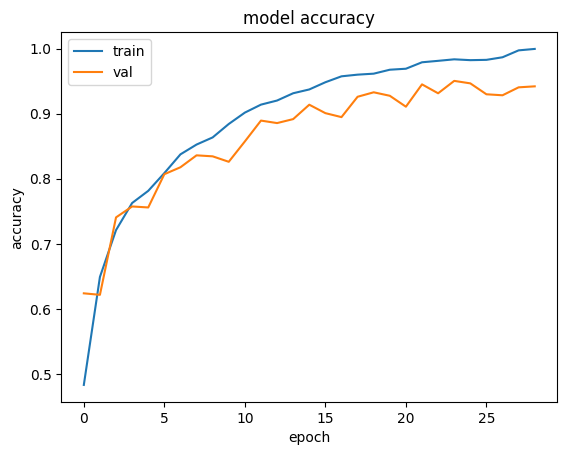

In [17]:
plt.plot(myModel.history['accuracy'])
plt.plot(myModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

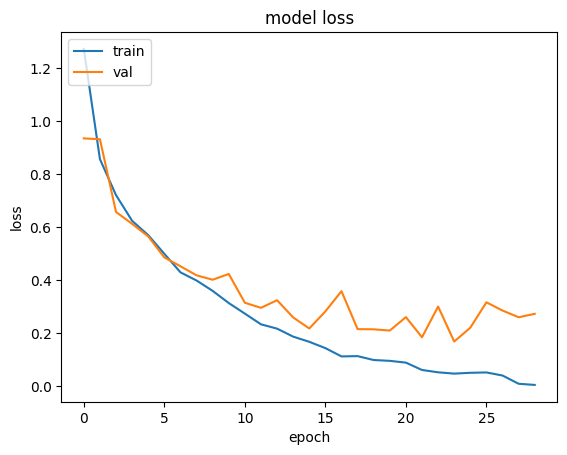

In [18]:
plt.plot(myModel.history['loss'])
plt.plot(myModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


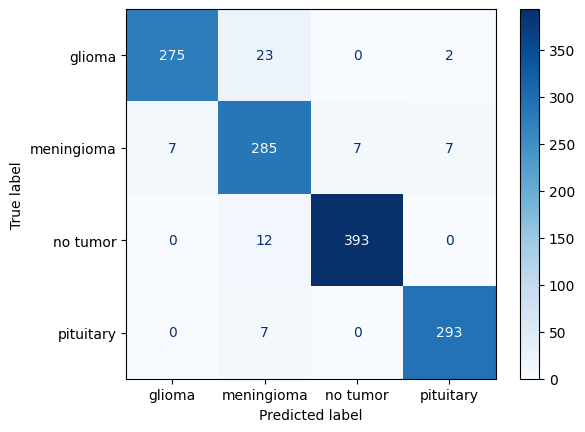

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.concatenate([y for x, y in test_data], axis=0)
# Use model_test instead of model
y_pred = model_test.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["glioma", "meningioma", "no tumor", "pituitary"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [20]:
model_test.save("SL_50_model(95).h5")

In [21]:
import os

TRAIN_DIR = "F1-10"

# Count image files
image_files = [f for f in os.listdir(TRAIN_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(f"Total number of images in '{TRAIN_DIR}': {len(image_files)}")

Total number of images in 'F1-10': 360


In [25]:
#Stacking 10% data into the Training
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tqdm import tqdm

# Define paths
MODEL_PATH = "SL_50_model(95).h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "F1-10"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
CONFIDENCE_THRESHOLD = 0.90
IMG_SIZE = (128, 128)

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])
        output_path = os.path.join(class_folder, img_file)
        img.save(output_path)

print("Pseudo-labeling completed. Check the output folder for labeled images.")

  0%|          | 0/1080 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


  0%|          | 1/1080 [00:00<13:38,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 3/1080 [00:00<04:24,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 5/1080 [00:01<02:43,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  1%|          | 7/1080 [00:01<02:03,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|          | 9/1080 [00:01<01:43, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|          | 11/1080 [00:01<01:31, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|          | 13/1080 [00:01<01:23, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  1%|▏         | 15/1080 [00:01<01:19, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|▏         | 17/1080 [00:01<01:14, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|▏         | 19/1080 [00:01<01:12, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 21/1080 [00:02<01:11, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|▏         | 23/1080 [00:02<01:18, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|▏         | 25/1080 [00:02<01:14, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▎         | 27/1080 [00:02<01:12, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 29/1080 [00:02<01:11, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 31/1080 [00:02<01:10, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  3%|▎         | 33/1080 [00:02<01:09, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  3%|▎         | 35/1080 [00:03<01:08, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 37/1080 [00:03<01:09, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▎         | 39/1080 [00:03<01:11, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 41/1080 [00:03<01:26, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  4%|▍         | 43/1080 [00:03<01:40, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  4%|▍         | 45/1080 [00:04<01:44,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▍         | 47/1080 [00:04<01:47,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|▍         | 49/1080 [00:04<01:49,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▍         | 50/1080 [00:04<01:53,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▍         | 52/1080 [00:04<01:56,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▍         | 53/1080 [00:04<01:54,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  5%|▌         | 55/1080 [00:05<01:53,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▌         | 57/1080 [00:05<01:38, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▌         | 59/1080 [00:05<01:27, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 61/1080 [00:05<01:20, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 63/1080 [00:05<01:15, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  6%|▌         | 65/1080 [00:05<01:13, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  6%|▌         | 67/1080 [00:05<01:10, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▋         | 69/1080 [00:06<01:09, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 71/1080 [00:06<01:16, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 73/1080 [00:06<01:12, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 75/1080 [00:06<01:10, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 77/1080 [00:06<01:07, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  7%|▋         | 79/1080 [00:06<01:06, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 81/1080 [00:06<01:07, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  8%|▊         | 83/1080 [00:07<01:06, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 85/1080 [00:07<01:11, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 87/1080 [00:07<01:09, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 89/1080 [00:07<01:07, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 91/1080 [00:07<01:06, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  9%|▊         | 93/1080 [00:07<01:05, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 95/1080 [00:07<01:05, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  9%|▉         | 97/1080 [00:07<01:04, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|▉         | 99/1080 [00:08<01:10, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  9%|▉         | 101/1080 [00:08<01:08, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|▉         | 103/1080 [00:08<01:06, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|▉         | 105/1080 [00:08<01:06, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|▉         | 107/1080 [00:08<01:05, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|█         | 109/1080 [00:08<01:04, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 10%|█         | 111/1080 [00:08<01:04, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 10%|█         | 113/1080 [00:09<01:03, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 11%|█         | 115/1080 [00:09<01:04, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 11%|█         | 117/1080 [00:09<01:04, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 119/1080 [00:09<01:35, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 121/1080 [00:09<01:25, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 11%|█▏        | 123/1080 [00:09<01:20, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 125/1080 [00:10<01:14, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 127/1080 [00:10<01:12, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 12%|█▏        | 129/1080 [00:10<01:08, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 131/1080 [00:10<01:12, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 12%|█▏        | 133/1080 [00:10<01:09, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 12%|█▎        | 135/1080 [00:10<01:06, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 137/1080 [00:10<01:05, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 13%|█▎        | 139/1080 [00:11<01:04, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 13%|█▎        | 141/1080 [00:11<01:09, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 143/1080 [00:11<01:07, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 13%|█▎        | 145/1080 [00:11<01:05, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▎        | 147/1080 [00:11<01:04, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 14%|█▍        | 149/1080 [00:11<01:01, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 14%|█▍        | 151/1080 [00:11<01:00, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 14%|█▍        | 153/1080 [00:11<01:01, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 155/1080 [00:12<01:07, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 15%|█▍        | 157/1080 [00:12<01:04, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 15%|█▍        | 159/1080 [00:12<01:02, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 15%|█▍        | 161/1080 [00:12<01:02, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 15%|█▌        | 163/1080 [00:12<01:01, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 15%|█▌        | 165/1080 [00:12<00:59, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 15%|█▌        | 167/1080 [00:12<01:01, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 169/1080 [00:13<01:05, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 16%|█▌        | 171/1080 [00:13<01:03, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 16%|█▌        | 173/1080 [00:13<01:02, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|█▌        | 175/1080 [00:13<01:00, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|█▋        | 177/1080 [00:13<00:59, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 17%|█▋        | 179/1080 [00:13<00:59, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 17%|█▋        | 181/1080 [00:13<00:58, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 17%|█▋        | 183/1080 [00:14<00:58, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 17%|█▋        | 185/1080 [00:14<01:04, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 17%|█▋        | 187/1080 [00:14<01:01, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 18%|█▊        | 189/1080 [00:14<01:00, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 18%|█▊        | 191/1080 [00:14<01:00, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 18%|█▊        | 193/1080 [00:14<00:59, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 18%|█▊        | 195/1080 [00:14<00:57, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 197/1080 [00:15<01:03, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 199/1080 [00:15<01:16, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▊        | 201/1080 [00:15<01:23, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 203/1080 [00:15<01:24, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 19%|█▉        | 205/1080 [00:15<01:21, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 207/1080 [00:16<01:25, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 19%|█▉        | 209/1080 [00:16<01:32,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|█▉        | 210/1080 [00:16<01:36,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█▉        | 212/1080 [00:16<01:36,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|█▉        | 214/1080 [00:16<01:36,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|█▉        | 215/1080 [00:17<01:34,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 20%|██        | 217/1080 [00:17<01:24, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 20%|██        | 219/1080 [00:17<01:14, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|██        | 221/1080 [00:17<01:09, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 21%|██        | 223/1080 [00:17<01:05, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 21%|██        | 225/1080 [00:17<01:02, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 21%|██        | 227/1080 [00:17<01:00, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 21%|██        | 229/1080 [00:17<00:58, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 21%|██▏       | 231/1080 [00:18<00:59, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|██▏       | 233/1080 [00:18<00:59, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 235/1080 [00:18<00:57, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|██▏       | 237/1080 [00:18<00:56, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 22%|██▏       | 239/1080 [00:18<00:56, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 241/1080 [00:18<00:55, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|██▎       | 243/1080 [00:18<00:54, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 23%|██▎       | 245/1080 [00:19<00:54, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 247/1080 [00:19<00:57, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 23%|██▎       | 249/1080 [00:19<01:02, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 23%|██▎       | 251/1080 [00:19<01:00, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 23%|██▎       | 253/1080 [00:19<00:58, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 24%|██▎       | 255/1080 [00:19<00:57, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 24%|██▍       | 257/1080 [00:19<00:56, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▍       | 259/1080 [00:20<01:00, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 24%|██▍       | 261/1080 [00:20<01:05, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▍       | 263/1080 [00:20<01:01, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 25%|██▍       | 265/1080 [00:20<00:59, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 25%|██▍       | 267/1080 [00:20<00:57, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 25%|██▍       | 269/1080 [00:20<00:55, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 25%|██▌       | 271/1080 [00:20<00:57, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 25%|██▌       | 273/1080 [00:21<00:55, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|██▌       | 275/1080 [00:21<01:01, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 277/1080 [00:21<00:59, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▌       | 279/1080 [00:21<00:57, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▌       | 281/1080 [00:21<00:56, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 26%|██▌       | 283/1080 [00:21<00:55, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▋       | 285/1080 [00:21<00:53, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 27%|██▋       | 287/1080 [00:22<00:53, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 289/1080 [00:22<00:56, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 291/1080 [00:22<00:59, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 27%|██▋       | 293/1080 [00:22<00:57, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 27%|██▋       | 295/1080 [00:22<00:55, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 28%|██▊       | 297/1080 [00:22<00:53, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|██▊       | 299/1080 [00:22<00:53, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|██▊       | 301/1080 [00:23<00:52, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 303/1080 [00:23<00:57, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 305/1080 [00:23<00:57, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|██▊       | 307/1080 [00:23<00:55, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 29%|██▊       | 309/1080 [00:23<00:54, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██▉       | 311/1080 [00:23<00:53, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██▉       | 313/1080 [00:23<00:52, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▉       | 315/1080 [00:24<00:51, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██▉       | 317/1080 [00:24<00:55, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 30%|██▉       | 319/1080 [00:24<00:54, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 30%|██▉       | 321/1080 [00:24<00:52, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 30%|██▉       | 323/1080 [00:24<00:52, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 30%|███       | 325/1080 [00:24<00:51, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 30%|███       | 327/1080 [00:24<00:50, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 30%|███       | 329/1080 [00:25<00:54, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███       | 331/1080 [00:25<00:53, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 333/1080 [00:25<00:53, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 335/1080 [00:25<00:52, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 31%|███       | 337/1080 [00:25<00:51, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███▏      | 339/1080 [00:25<00:51, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 32%|███▏      | 341/1080 [00:25<00:49, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 32%|███▏      | 343/1080 [00:25<00:49, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 345/1080 [00:26<00:53, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 347/1080 [00:26<00:57, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 349/1080 [00:26<00:55, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▎      | 351/1080 [00:26<00:53, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 33%|███▎      | 353/1080 [00:26<00:51, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 33%|███▎      | 355/1080 [00:26<00:50, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 33%|███▎      | 357/1080 [00:26<00:49, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|███▎      | 359/1080 [00:27<01:03, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 361/1080 [00:27<01:09, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▎      | 363/1080 [00:27<01:13,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 365/1080 [00:27<01:17,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|███▍      | 366/1080 [00:28<01:19,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 367/1080 [00:28<01:21,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 368/1080 [00:28<01:23,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 369/1080 [00:28<01:25,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|███▍      | 370/1080 [00:28<01:24,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|███▍      | 371/1080 [00:28<01:22,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 372/1080 [00:28<01:25,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 35%|███▍      | 374/1080 [00:28<01:07, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▍      | 376/1080 [00:29<01:05, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 35%|███▌      | 378/1080 [00:29<00:58, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 35%|███▌      | 380/1080 [00:29<00:55, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|███▌      | 382/1080 [00:29<00:58, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 36%|███▌      | 384/1080 [00:29<00:54, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 36%|███▌      | 386/1080 [00:29<00:52, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 36%|███▌      | 388/1080 [00:30<00:49, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▌      | 390/1080 [00:30<00:53, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 36%|███▋      | 392/1080 [00:30<00:50, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▋      | 394/1080 [00:30<00:59, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 37%|███▋      | 396/1080 [00:30<00:55, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 37%|███▋      | 398/1080 [00:30<00:52, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 37%|███▋      | 400/1080 [00:30<00:49, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 402/1080 [00:31<00:48, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 37%|███▋      | 404/1080 [00:31<00:48, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 38%|███▊      | 406/1080 [00:31<00:47, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 38%|███▊      | 408/1080 [00:31<00:47, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 38%|███▊      | 410/1080 [00:31<00:47, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 38%|███▊      | 412/1080 [00:31<00:45, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 38%|███▊      | 414/1080 [00:31<00:45, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 39%|███▊      | 416/1080 [00:32<00:44, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▊      | 418/1080 [00:32<00:45, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 39%|███▉      | 420/1080 [00:32<00:46, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 422/1080 [00:32<00:45, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 39%|███▉      | 424/1080 [00:32<00:45, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 39%|███▉      | 426/1080 [00:32<00:44, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 40%|███▉      | 428/1080 [00:32<00:43, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|███▉      | 430/1080 [00:33<00:47, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|████      | 432/1080 [00:33<00:50, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 40%|████      | 434/1080 [00:33<00:48, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 436/1080 [00:33<00:50, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 41%|████      | 438/1080 [00:33<00:49, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 41%|████      | 440/1080 [00:33<00:46, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████      | 442/1080 [00:33<00:45, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████      | 444/1080 [00:34<00:48, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████▏     | 446/1080 [00:34<00:47, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 41%|████▏     | 448/1080 [00:34<00:45, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 450/1080 [00:34<00:45, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 42%|████▏     | 452/1080 [00:34<00:44, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 42%|████▏     | 454/1080 [00:34<00:43, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 42%|████▏     | 456/1080 [00:34<00:42, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 42%|████▏     | 458/1080 [00:35<00:41, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 43%|████▎     | 460/1080 [00:35<00:46, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 43%|████▎     | 462/1080 [00:35<00:44, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 43%|████▎     | 464/1080 [00:35<00:43, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 43%|████▎     | 466/1080 [00:35<00:44, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 468/1080 [00:35<00:46, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 44%|████▎     | 470/1080 [00:35<00:45, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▎     | 472/1080 [00:36<00:47, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 44%|████▍     | 474/1080 [00:36<00:45, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 44%|████▍     | 476/1080 [00:36<00:44, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 478/1080 [00:36<00:47, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 480/1080 [00:36<00:48, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▍     | 482/1080 [00:36<00:46, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 45%|████▍     | 484/1080 [00:37<00:43, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 45%|████▌     | 486/1080 [00:37<00:46, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▌     | 488/1080 [00:37<00:44, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|████▌     | 490/1080 [00:37<00:43, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 492/1080 [00:37<00:46, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 46%|████▌     | 494/1080 [00:37<00:44, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 46%|████▌     | 496/1080 [00:37<00:42, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 498/1080 [00:38<00:45, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▋     | 500/1080 [00:38<00:47, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 46%|████▋     | 502/1080 [00:38<00:44, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 504/1080 [00:38<00:43, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 506/1080 [00:38<00:43, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|████▋     | 508/1080 [00:38<00:46, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 510/1080 [00:39<00:54, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 512/1080 [00:39<00:56,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 48%|████▊     | 514/1080 [00:39<00:59,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 515/1080 [00:39<01:01,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 517/1080 [00:39<00:58,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 519/1080 [00:40<00:59,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 521/1080 [00:40<01:00,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 522/1080 [00:40<01:02,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 48%|████▊     | 523/1080 [00:40<01:02,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 49%|████▊     | 524/1080 [00:40<01:03,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|████▊     | 526/1080 [00:40<00:53, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 49%|████▉     | 528/1080 [00:41<00:51, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|████▉     | 530/1080 [00:41<00:47, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 49%|████▉     | 532/1080 [00:41<00:43, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|████▉     | 534/1080 [00:41<00:44, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 50%|████▉     | 536/1080 [00:41<00:41, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|████▉     | 538/1080 [00:41<00:44, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 50%|█████     | 540/1080 [00:41<00:41, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 542/1080 [00:42<00:40, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|█████     | 544/1080 [00:42<00:42, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 51%|█████     | 546/1080 [00:42<00:40, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 548/1080 [00:42<00:46, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 51%|█████     | 550/1080 [00:42<00:44, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 51%|█████     | 552/1080 [00:43<00:45, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 51%|█████▏    | 554/1080 [00:43<00:43, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 51%|█████▏    | 556/1080 [00:43<00:40, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 52%|█████▏    | 558/1080 [00:43<00:39, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 52%|█████▏    | 560/1080 [00:43<00:37, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 562/1080 [00:43<00:40, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 52%|█████▏    | 564/1080 [00:43<00:39, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 52%|█████▏    | 566/1080 [00:44<00:38, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 53%|█████▎    | 568/1080 [00:44<00:41, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 53%|█████▎    | 570/1080 [00:44<00:39, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 53%|█████▎    | 572/1080 [00:44<00:37, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 574/1080 [00:44<00:36, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 53%|█████▎    | 576/1080 [00:44<00:36, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 54%|█████▎    | 578/1080 [00:44<00:38, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▎    | 580/1080 [00:45<00:37, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 54%|█████▍    | 582/1080 [00:45<00:39, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 584/1080 [00:45<00:37, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 54%|█████▍    | 586/1080 [00:45<00:39, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 54%|█████▍    | 588/1080 [00:45<00:41, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▍    | 590/1080 [00:45<00:42, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▍    | 592/1080 [00:46<00:40, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 55%|█████▌    | 594/1080 [00:46<00:38, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 55%|█████▌    | 596/1080 [00:46<00:36, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 55%|█████▌    | 598/1080 [00:46<00:38, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 56%|█████▌    | 600/1080 [00:46<00:39, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 602/1080 [00:46<00:37, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 56%|█████▌    | 604/1080 [00:47<00:35, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 56%|█████▌    | 606/1080 [00:47<00:35, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 56%|█████▋    | 608/1080 [00:47<00:37, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 56%|█████▋    | 610/1080 [00:47<00:35, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 612/1080 [00:47<00:34, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 614/1080 [00:47<00:39, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|█████▋    | 616/1080 [00:47<00:37, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 618/1080 [00:48<00:35, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 57%|█████▋    | 620/1080 [00:48<00:34, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 622/1080 [00:48<00:33, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 58%|█████▊    | 624/1080 [00:48<00:36, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 58%|█████▊    | 626/1080 [00:48<00:34, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 58%|█████▊    | 628/1080 [00:48<00:33, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 58%|█████▊    | 630/1080 [00:49<00:35, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▊    | 632/1080 [00:49<00:35, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▊    | 634/1080 [00:49<00:33, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▉    | 636/1080 [00:49<00:35, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 59%|█████▉    | 638/1080 [00:49<00:33, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 59%|█████▉    | 640/1080 [00:49<00:32, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 642/1080 [00:49<00:34, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 644/1080 [00:50<00:36, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|█████▉    | 646/1080 [00:50<00:37, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 60%|██████    | 648/1080 [00:50<00:37, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 60%|██████    | 650/1080 [00:50<00:35, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|██████    | 652/1080 [00:50<00:36, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 61%|██████    | 654/1080 [00:51<00:43,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 656/1080 [00:51<00:44,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 658/1080 [00:51<00:44,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 659/1080 [00:51<00:44,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 660/1080 [00:51<00:44,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 662/1080 [00:51<00:44,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████▏   | 663/1080 [00:52<00:47,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████▏   | 664/1080 [00:52<00:48,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 665/1080 [00:52<00:50,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 666/1080 [00:52<00:48,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 667/1080 [00:52<00:50,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 668/1080 [00:52<00:51,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 62%|██████▏   | 669/1080 [00:52<00:52,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 671/1080 [00:53<00:45,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 62%|██████▏   | 673/1080 [00:53<00:38, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 62%|██████▎   | 675/1080 [00:53<00:35, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 63%|██████▎   | 677/1080 [00:53<00:32, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 63%|██████▎   | 679/1080 [00:53<00:31, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 681/1080 [00:53<00:30, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 683/1080 [00:53<00:31, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 685/1080 [00:54<00:33, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▎   | 687/1080 [00:54<00:34, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 689/1080 [00:54<00:34, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▍   | 691/1080 [00:54<00:32, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 64%|██████▍   | 693/1080 [00:54<00:30, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▍   | 695/1080 [00:54<00:29, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▍   | 697/1080 [00:55<00:31, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 65%|██████▍   | 699/1080 [00:55<00:29, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 65%|██████▍   | 701/1080 [00:55<00:30, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 65%|██████▌   | 703/1080 [00:55<00:28, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 65%|██████▌   | 705/1080 [00:55<00:27, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 65%|██████▌   | 707/1080 [00:55<00:29, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 709/1080 [00:56<00:32, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 66%|██████▌   | 711/1080 [00:56<00:32, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 713/1080 [00:56<00:34, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 66%|██████▌   | 715/1080 [00:56<00:32, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 66%|██████▋   | 717/1080 [00:56<00:32, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 67%|██████▋   | 719/1080 [00:56<00:30, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 721/1080 [00:57<00:31, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 723/1080 [00:57<00:29, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 725/1080 [00:57<00:30, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 67%|██████▋   | 727/1080 [00:57<00:28, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 68%|██████▊   | 729/1080 [00:57<00:27, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 731/1080 [00:57<00:26, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 733/1080 [00:58<00:28, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 68%|██████▊   | 735/1080 [00:58<00:29, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 68%|██████▊   | 737/1080 [00:58<00:27, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 68%|██████▊   | 739/1080 [00:58<00:28, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 69%|██████▊   | 741/1080 [00:58<00:26, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▉   | 743/1080 [00:58<00:26, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 745/1080 [00:59<00:29, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|██████▉   | 747/1080 [00:59<00:29, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 69%|██████▉   | 749/1080 [00:59<00:27, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|██████▉   | 751/1080 [00:59<00:28, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|██████▉   | 753/1080 [00:59<00:26, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|██████▉   | 755/1080 [00:59<00:25, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 757/1080 [01:00<00:27, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|███████   | 759/1080 [01:00<00:26, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|███████   | 761/1080 [01:00<00:29, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 71%|███████   | 763/1080 [01:00<00:28, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 71%|███████   | 765/1080 [01:00<00:26, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 71%|███████   | 767/1080 [01:00<00:25, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 769/1080 [01:01<00:26, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 71%|███████▏  | 771/1080 [01:01<00:26, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 72%|███████▏  | 773/1080 [01:01<00:26, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 72%|███████▏  | 775/1080 [01:01<00:24, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 72%|███████▏  | 777/1080 [01:01<00:23, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████▏  | 779/1080 [01:01<00:23, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 781/1080 [01:02<00:23, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▎  | 783/1080 [01:02<00:25, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 73%|███████▎  | 785/1080 [01:02<00:24, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 73%|███████▎  | 787/1080 [01:02<00:24, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 73%|███████▎  | 789/1080 [01:02<00:23, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|███████▎  | 791/1080 [01:02<00:24, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|███████▎  | 793/1080 [01:03<00:26, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▎  | 795/1080 [01:03<00:28,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 74%|███████▍  | 797/1080 [01:03<00:30,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▍  | 798/1080 [01:03<00:29,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 799/1080 [01:03<00:31,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 800/1080 [01:04<00:32,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 801/1080 [01:04<00:34,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 74%|███████▍  | 802/1080 [01:04<00:33,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 803/1080 [01:04<00:33,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 804/1080 [01:04<00:34,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 75%|███████▍  | 805/1080 [01:04<00:34,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|███████▍  | 806/1080 [01:04<00:33,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▍  | 807/1080 [01:04<00:34,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▍  | 809/1080 [01:05<00:29,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▌  | 811/1080 [01:05<00:27,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 75%|███████▌  | 813/1080 [01:05<00:24, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▌  | 815/1080 [01:05<00:26, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 817/1080 [01:05<00:23, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 819/1080 [01:05<00:21, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 821/1080 [01:06<00:22, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 76%|███████▌  | 823/1080 [01:06<00:20, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▋  | 825/1080 [01:06<00:21, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 827/1080 [01:06<00:20, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 829/1080 [01:06<00:21, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|███████▋  | 831/1080 [01:06<00:21, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 833/1080 [01:07<00:21, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 77%|███████▋  | 835/1080 [01:07<00:20, 11.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 837/1080 [01:07<00:22, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 839/1080 [01:07<00:23, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 841/1080 [01:07<00:22, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 843/1080 [01:08<00:22, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 78%|███████▊  | 845/1080 [01:08<00:20, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 847/1080 [01:08<00:20, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 79%|███████▊  | 849/1080 [01:08<00:19, 11.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▉  | 851/1080 [01:08<00:21, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▉  | 853/1080 [01:08<00:20, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 855/1080 [01:09<00:19, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▉  | 857/1080 [01:09<00:19, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 80%|███████▉  | 859/1080 [01:09<00:18, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 80%|███████▉  | 861/1080 [01:09<00:17, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 80%|███████▉  | 863/1080 [01:09<00:17, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 80%|████████  | 865/1080 [01:09<00:19, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 867/1080 [01:10<00:18, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 869/1080 [01:10<00:18, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 81%|████████  | 871/1080 [01:10<00:17, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 81%|████████  | 873/1080 [01:10<00:17, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 875/1080 [01:10<00:16, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 81%|████████  | 877/1080 [01:10<00:16, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████▏ | 879/1080 [01:11<00:16, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 82%|████████▏ | 881/1080 [01:11<00:17, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 82%|████████▏ | 883/1080 [01:11<00:16, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 885/1080 [01:11<00:15, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 887/1080 [01:11<00:16, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 889/1080 [01:11<00:16, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▎ | 891/1080 [01:12<00:15, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 83%|████████▎ | 893/1080 [01:12<00:15, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 83%|████████▎ | 895/1080 [01:12<00:14, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 897/1080 [01:12<00:14, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 899/1080 [01:12<00:16, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 901/1080 [01:13<00:17, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 84%|████████▎ | 903/1080 [01:13<00:16, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 905/1080 [01:13<00:15, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|████████▍ | 907/1080 [01:13<00:16, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 84%|████████▍ | 909/1080 [01:13<00:15, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 84%|████████▍ | 911/1080 [01:13<00:14, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▍ | 913/1080 [01:14<00:15, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▍ | 915/1080 [01:14<00:14, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 85%|████████▍ | 917/1080 [01:14<00:13, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 85%|████████▌ | 919/1080 [01:14<00:12, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 85%|████████▌ | 921/1080 [01:14<00:12, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▌ | 923/1080 [01:14<00:11, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▌ | 925/1080 [01:15<00:13, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 927/1080 [01:15<00:14, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 929/1080 [01:15<00:15, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 931/1080 [01:15<00:15,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▋ | 933/1080 [01:15<00:16,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▋ | 934/1080 [01:16<00:17,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 935/1080 [01:16<00:17,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|████████▋ | 936/1080 [01:16<00:16,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 937/1080 [01:16<00:17,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 87%|████████▋ | 938/1080 [01:16<00:16,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 939/1080 [01:16<00:17,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 940/1080 [01:16<00:17,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|████████▋ | 941/1080 [01:17<00:17,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 87%|████████▋ | 943/1080 [01:17<00:15,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████▊ | 945/1080 [01:17<00:14,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 946/1080 [01:17<00:14,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 947/1080 [01:17<00:14,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████▊ | 948/1080 [01:17<00:14,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 88%|████████▊ | 950/1080 [01:17<00:12, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 88%|████████▊ | 952/1080 [01:18<00:11, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████▊ | 954/1080 [01:18<00:11, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▊ | 956/1080 [01:18<00:12, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▊ | 958/1080 [01:18<00:11, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 960/1080 [01:18<00:10, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▉ | 962/1080 [01:19<00:11, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 964/1080 [01:19<00:11,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 89%|████████▉ | 966/1080 [01:19<00:10, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 90%|████████▉ | 968/1080 [01:19<00:09, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 90%|████████▉ | 970/1080 [01:19<00:09, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 90%|█████████ | 972/1080 [01:19<00:09, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|█████████ | 974/1080 [01:20<00:09, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|█████████ | 976/1080 [01:20<00:10, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 91%|█████████ | 978/1080 [01:20<00:09, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████ | 980/1080 [01:20<00:08, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████ | 982/1080 [01:20<00:08, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████ | 984/1080 [01:21<00:09, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████▏| 986/1080 [01:21<00:09,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████▏| 988/1080 [01:21<00:09, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 990/1080 [01:21<00:08, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 92%|█████████▏| 992/1080 [01:21<00:07, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 994/1080 [01:21<00:07, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 996/1080 [01:22<00:07, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 998/1080 [01:22<00:07, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 93%|█████████▎| 1000/1080 [01:22<00:07, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 93%|█████████▎| 1002/1080 [01:22<00:06, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 93%|█████████▎| 1004/1080 [01:22<00:06, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 1006/1080 [01:23<00:06, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 93%|█████████▎| 1008/1080 [01:23<00:06, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▎| 1010/1080 [01:23<00:06, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▎| 1012/1080 [01:23<00:05, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 94%|█████████▍| 1014/1080 [01:23<00:05, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 1016/1080 [01:23<00:05, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 94%|█████████▍| 1018/1080 [01:24<00:05, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 1020/1080 [01:24<00:04, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▍| 1022/1080 [01:24<00:05, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▍| 1024/1080 [01:24<00:04, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 95%|█████████▌| 1026/1080 [01:24<00:04, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 95%|█████████▌| 1028/1080 [01:24<00:04, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▌| 1030/1080 [01:25<00:04, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|█████████▌| 1032/1080 [01:25<00:04, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 96%|█████████▌| 1034/1080 [01:25<00:04, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 96%|█████████▌| 1036/1080 [01:25<00:04, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 96%|█████████▌| 1038/1080 [01:25<00:04, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|█████████▋| 1040/1080 [01:26<00:04,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 96%|█████████▋| 1042/1080 [01:26<00:03, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 1044/1080 [01:26<00:03, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 1046/1080 [01:26<00:03, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 97%|█████████▋| 1048/1080 [01:26<00:02, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 1050/1080 [01:27<00:02, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 97%|█████████▋| 1052/1080 [01:27<00:02,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|█████████▊| 1053/1080 [01:27<00:02,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 1055/1080 [01:27<00:02,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 1056/1080 [01:27<00:02,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 1058/1080 [01:27<00:02,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 1059/1080 [01:28<00:02,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|█████████▊| 1060/1080 [01:28<00:02,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|█████████▊| 1061/1080 [01:28<00:02,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|█████████▊| 1062/1080 [01:28<00:02,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▊| 1064/1080 [01:28<00:01,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▊| 1065/1080 [01:28<00:01,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▊| 1066/1080 [01:28<00:01,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 99%|█████████▉| 1067/1080 [01:29<00:01,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 1068/1080 [01:29<00:01,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 1070/1080 [01:29<00:01,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 1071/1080 [01:29<00:00,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 1073/1080 [01:29<00:00, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


100%|█████████▉| 1075/1080 [01:29<00:00, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|█████████▉| 1077/1080 [01:30<00:00, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


100%|█████████▉| 1079/1080 [01:30<00:00, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


100%|██████████| 1080/1080 [01:30<00:00, 11.96it/s]

Pseudo-labeling completed. Check the output folder for labeled images.


In [27]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "BT100/Training",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

Found 9450 files belonging to 4 classes.


In [23]:
#Data Augmentaion of 10% unlabelled
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Define paths
TRAIN_DIR = "F1-10"

# Define augmentation functions
def augment_image(image):
    """Apply rotation, flipping, zoom, brightness, and contrast adjustments."""

    # Random Rotation (-20 to +20 degrees)
    image = tf.image.rot90(image, k=random.choice([0, 1, 2, 3]))

    # Random Flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random Zoom (Crop and Resize)
    crop_fraction = random.uniform(0.7, 1.0)  # Zoom range
    img_shape = tf.shape(image)

    # Cast img_shape elements to float32 before multiplication
    crop_size = [int(tf.cast(img_shape[0], tf.float32) * crop_fraction),
                 int(tf.cast(img_shape[1], tf.float32) * crop_fraction), 3]

    image = tf.image.random_crop(image, crop_size)
    image = tf.image.resize(image, (img_shape[0], img_shape[1]))

    # Random Brightness and Contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image

# Get image files
image_files = [f for f in os.listdir(TRAIN_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
num_augmented = len(image_files) * 2  # Generate double the dataset size

for i in range(num_augmented):
    img_name = random.choice(image_files)  # Pick a random image
    img_path = os.path.join(TRAIN_DIR, img_name)

    # Load image
    image = load_img(img_path)
    image = img_to_array(image) / 255.0  # Normalize

    # Apply augmentation
    augmented_image = augment_image(image)

    # Convert back to image
    augmented_image = array_to_img(augmented_image)

    # Save augmented image in the same folder
    new_filename = f"aug_{i}_{img_name}"
    augmented_image.save(os.path.join(TRAIN_DIR, new_filename))

print("Augmentation complete! Images saved in the existing training folder.")


Augmentation complete! Images saved in the existing training folder.


In [24]:
import os

TRAIN_DIR = "F1-10"

# Count image files
image_files = [f for f in os.listdir(TRAIN_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(f"Total number of images in '{TRAIN_DIR}': {len(image_files)}")


Total number of images in 'F1-10': 1080


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_refined_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(4, activation='softmax')  # 4 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_1 = create_refined_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [32]:
SSL_model_1 = model_1.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.3756 - loss: 2.0279 - val_accuracy: 0.6102 - val_loss: 1.0217 - learning_rate: 5.0000e-04
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5964 - loss: 0.9730 - val_accuracy: 0.6278 - val_loss: 0.9296 - learning_rate: 5.0000e-04
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6605 - loss: 0.8397 - val_accuracy: 0.6773 - val_loss: 0.8804 - learning_rate: 5.0000e-04
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.7297 - loss: 0.7142 - val_accuracy: 0.7727 - val_loss: 0.6338 - learning_rate: 5.0000e-04
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7753 - loss: 0.6050 - val_accuracy: 0.7788 - val_loss: 0.6345 - learning_rate: 5.0000e-04
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7981 - loss: 0.5316 - val_accuracy: 0.7735 - val_loss: 0.5962 - learning_rate: 5.0000e-04
Epoch 7/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step

In [33]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# Get true labels from test_data
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())

y_true = np.argmax(y_true, axis=1)  # Convert one-hot to class labels

# Get predictions from the model
y_pred = model_1.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Convert true labels to one-hot format
encoder = OneHotEncoder(sparse_output=False)  # Ensure dense output
y_true_onehot = encoder.fit_transform(y_true.reshape(-1, 1))
y_pred_onehot = encoder.transform(y_pred.reshape(-1, 1))

# Print classification report
print(classification_report(y_true_onehot, y_pred_onehot, zero_division=1))


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Accuracy: 0.9191456903127384
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       300
           1       0.87      0.80      0.83       306
           2       0.93      0.98      0.95       405
           3       0.97      0.98      0.98       300

   micro avg       0.92      0.92      0.92      1311
   macro avg       0.92      0.91      0.92      1311
weighted avg       0.92      0.92      0.92      1311
 samples avg       0.92      0.92      0.92      1311



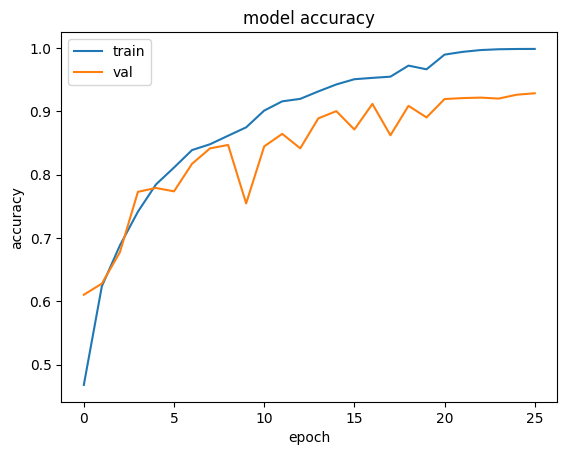

In [34]:
plt.plot(SSL_model_1.history['accuracy'])
plt.plot(SSL_model_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

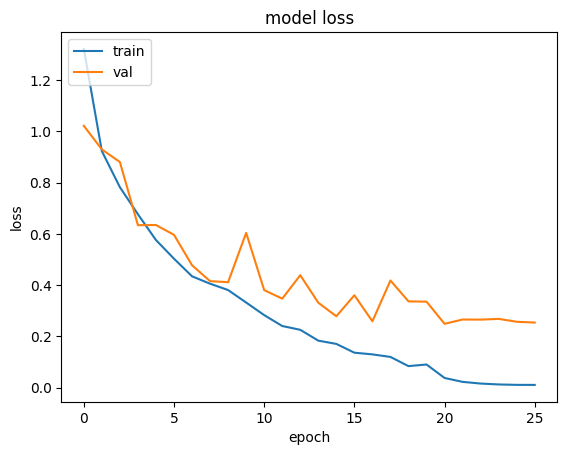

In [35]:
plt.plot(SSL_model_1.history['loss'])
plt.plot(SSL_model_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


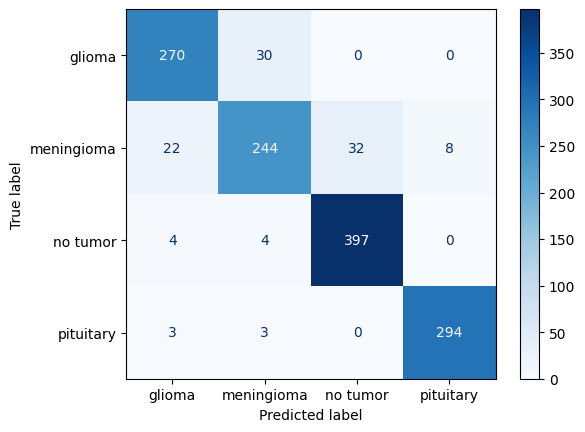

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.concatenate([y for x, y in test_data], axis=0)
# Use model_test instead of model
y_pred = model_1.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["glioma", "meningioma", "no tumor", "pituitary"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [42]:
import os

TRAIN_DIR = "F2-10"

# Count image files
image_files = [f for f in os.listdir(TRAIN_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(f"Total number of images in '{TRAIN_DIR}': {len(image_files)}")


Total number of images in 'F2-10': 1080


In [41]:
#Data Augmentaion of 10% unlabelled
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Define paths
TRAIN_DIR = "F2-10"

# Define augmentation functions
def augment_image(image):
    """Apply rotation, flipping, zoom, brightness, and contrast adjustments."""

    # Random Rotation (-20 to +20 degrees)
    image = tf.image.rot90(image, k=random.choice([0, 1, 2, 3]))

    # Random Flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random Zoom (Crop and Resize)
    crop_fraction = random.uniform(0.7, 1.0)  # Zoom range
    img_shape = tf.shape(image)

    # Cast img_shape elements to float32 before multiplication
    crop_size = [int(tf.cast(img_shape[0], tf.float32) * crop_fraction),
                 int(tf.cast(img_shape[1], tf.float32) * crop_fraction), 3]

    image = tf.image.random_crop(image, crop_size)
    image = tf.image.resize(image, (img_shape[0], img_shape[1]))

    # Random Brightness and Contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image

# Get image files
image_files = [f for f in os.listdir(TRAIN_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
num_augmented = len(image_files) * 2  # Generate double the dataset size

for i in range(num_augmented):
    img_name = random.choice(image_files)  # Pick a random image
    img_path = os.path.join(TRAIN_DIR, img_name)

    # Load image
    image = load_img(img_path)
    image = img_to_array(image) / 255.0  # Normalize

    # Apply augmentation
    augmented_image = augment_image(image)

    # Convert back to image
    augmented_image = array_to_img(augmented_image)

    # Save augmented image in the same folder
    new_filename = f"aug_{i}_{img_name}"
    augmented_image.save(os.path.join(TRAIN_DIR, new_filename))

print("Augmentation complete! Images saved in the existing training folder.")


Augmentation complete! Images saved in the existing training folder.


In [1]:
#Stacking 10% data into the Training
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tqdm import tqdm

# Define paths
MODEL_PATH = "SL_50_model(95).h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "F2-10"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
CONFIDENCE_THRESHOLD = 0.90
IMG_SIZE = (128, 128)

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])
        output_path = os.path.join(class_folder, img_file)
        img.save(output_path)

print("Pseudo-labeling completed. Check the output folder for labeled images.")

  0%|          | 0/1080 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 1/1080 [00:01<24:27,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 2/1080 [00:01<11:30,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 3/1080 [00:01<07:22,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 4/1080 [00:01<05:26,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 6/1080 [00:01<03:12,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 8/1080 [00:02<02:19,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|          | 10/1080 [00:02<01:55,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 12/1080 [00:02<01:39, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|▏         | 14/1080 [00:02<01:31, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|▏         | 16/1080 [00:02<01:26, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 18/1080 [00:02<01:30, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 20/1080 [00:02<01:23, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 22/1080 [00:03<01:18, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 24/1080 [00:03<01:20, 13.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 26/1080 [00:03<01:18, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 28/1080 [00:03<01:16, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 30/1080 [00:03<01:14, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 32/1080 [00:03<01:14, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 34/1080 [00:03<01:12, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 36/1080 [00:04<01:11, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▎         | 38/1080 [00:04<01:11, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▎         | 40/1080 [00:04<01:11, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▍         | 42/1080 [00:04<01:11, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▍         | 44/1080 [00:04<01:10, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 46/1080 [00:04<01:17, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 48/1080 [00:04<01:14, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▍         | 50/1080 [00:05<01:12, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 52/1080 [00:05<01:18, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▌         | 54/1080 [00:05<01:14, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▌         | 56/1080 [00:05<01:13, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▌         | 58/1080 [00:05<01:11, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 60/1080 [00:05<01:17, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 62/1080 [00:05<01:14, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 64/1080 [00:06<01:13, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 66/1080 [00:06<01:19, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▋         | 68/1080 [00:06<01:16, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▋         | 70/1080 [00:06<01:12, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 72/1080 [00:06<01:16, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 74/1080 [00:06<01:13, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 76/1080 [00:06<01:11, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 78/1080 [00:07<01:10, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 80/1080 [00:07<01:10, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 82/1080 [00:07<01:09, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 84/1080 [00:07<01:10, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  8%|▊         | 86/1080 [00:07<01:17, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 88/1080 [00:07<01:14, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 90/1080 [00:07<01:12, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▊         | 92/1080 [00:08<01:10, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▊         | 94/1080 [00:08<01:15, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 96/1080 [00:08<01:13, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 98/1080 [00:08<01:11, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 100/1080 [00:08<01:19, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 102/1080 [00:08<01:15, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|▉         | 104/1080 [00:09<01:12, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|▉         | 106/1080 [00:09<01:10, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|█         | 108/1080 [00:09<01:14, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|█         | 110/1080 [00:09<01:11, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 112/1080 [00:09<01:15, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 11%|█         | 114/1080 [00:09<01:12, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 11%|█         | 116/1080 [00:09<01:16, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 118/1080 [00:10<01:19, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█         | 120/1080 [00:10<01:20, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█▏        | 122/1080 [00:10<01:15, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█▏        | 124/1080 [00:10<01:12, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 126/1080 [00:10<01:21, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 128/1080 [00:10<01:16, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 130/1080 [00:11<01:11, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 12%|█▏        | 132/1080 [00:11<01:08, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 134/1080 [00:11<01:07, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 136/1080 [00:11<01:05, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 138/1080 [00:11<01:04, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 140/1080 [00:11<01:10, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|█▎        | 142/1080 [00:12<01:25, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█▎        | 144/1080 [00:12<01:35,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▎        | 146/1080 [00:12<01:40,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▎        | 148/1080 [00:12<01:38,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 14%|█▍        | 149/1080 [00:12<01:42,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▍        | 150/1080 [00:12<01:41,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█▍        | 151/1080 [00:13<01:44,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 14%|█▍        | 152/1080 [00:13<01:51,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█▍        | 153/1080 [00:13<01:46,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▍        | 154/1080 [00:13<01:45,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▍        | 155/1080 [00:13<01:50,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 14%|█▍        | 156/1080 [00:13<01:54,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▍        | 157/1080 [00:13<01:56,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▍        | 159/1080 [00:13<01:33,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▍        | 161/1080 [00:14<01:21, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▌        | 163/1080 [00:14<01:13, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▌        | 165/1080 [00:14<01:09, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▌        | 167/1080 [00:14<01:07, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 169/1080 [00:14<01:11, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|█▌        | 171/1080 [00:14<01:08, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▌        | 173/1080 [00:14<01:06, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 175/1080 [00:15<01:10, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▋        | 177/1080 [00:15<01:07, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 179/1080 [00:15<01:05, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 181/1080 [00:15<01:05, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 183/1080 [00:15<01:05, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 185/1080 [00:15<01:10, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 187/1080 [00:16<01:13, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|█▊        | 189/1080 [00:16<01:40,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 18%|█▊        | 191/1080 [00:16<02:01,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 18%|█▊        | 192/1080 [00:17<02:27,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 193/1080 [00:17<02:30,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|█▊        | 194/1080 [00:17<02:18,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 18%|█▊        | 195/1080 [00:17<02:16,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 18%|█▊        | 196/1080 [00:17<02:15,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 18%|█▊        | 197/1080 [00:17<02:19,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 18%|█▊        | 198/1080 [00:18<02:13,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 199/1080 [00:18<02:06,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 19%|█▊        | 200/1080 [00:18<02:12,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|█▊        | 201/1080 [00:18<02:09,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|█▊        | 202/1080 [00:18<02:41,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|█▉        | 203/1080 [00:18<02:26,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|█▉        | 204/1080 [00:19<02:30,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 19%|█▉        | 205/1080 [00:19<02:27,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▉        | 206/1080 [00:19<02:14,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▉        | 208/1080 [00:19<01:40,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 210/1080 [00:19<01:32,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 20%|█▉        | 211/1080 [00:19<01:51,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 20%|█▉        | 212/1080 [00:20<02:17,  6.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|█▉        | 213/1080 [00:20<02:30,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|█▉        | 214/1080 [00:20<02:14,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 20%|█▉        | 215/1080 [00:20<02:28,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|██        | 216/1080 [00:20<02:28,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|██        | 217/1080 [00:21<02:33,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 20%|██        | 218/1080 [00:21<02:41,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 20%|██        | 219/1080 [00:21<02:58,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 20%|██        | 220/1080 [00:21<03:12,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 20%|██        | 221/1080 [00:22<03:29,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 21%|██        | 222/1080 [00:22<03:42,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 21%|██        | 223/1080 [00:22<03:41,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 21%|██        | 224/1080 [00:22<03:41,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 21%|██        | 225/1080 [00:23<03:44,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 21%|██        | 226/1080 [00:23<03:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 21%|██        | 227/1080 [00:23<03:40,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██        | 228/1080 [00:23<03:22,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 21%|██        | 229/1080 [00:24<03:14,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 21%|██▏       | 230/1080 [00:24<03:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 21%|██▏       | 231/1080 [00:24<03:42,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 21%|██▏       | 232/1080 [00:24<03:36,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|██▏       | 233/1080 [00:25<03:48,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 22%|██▏       | 234/1080 [00:25<03:15,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 22%|██▏       | 235/1080 [00:25<03:20,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 22%|██▏       | 236/1080 [00:25<03:26,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 22%|██▏       | 237/1080 [00:26<03:06,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|██▏       | 238/1080 [00:26<02:52,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 239/1080 [00:26<02:27,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 240/1080 [00:26<02:15,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|██▏       | 241/1080 [00:26<02:08,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 242/1080 [00:26<02:03,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 23%|██▎       | 244/1080 [00:26<01:33,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 246/1080 [00:26<01:20, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 23%|██▎       | 248/1080 [00:27<01:17, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 250/1080 [00:27<01:22, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 23%|██▎       | 252/1080 [00:27<01:13, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▎       | 254/1080 [00:27<01:08, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 24%|██▎       | 256/1080 [00:27<01:05, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 258/1080 [00:27<01:07, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▍       | 260/1080 [00:28<01:03, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 262/1080 [00:28<01:02, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 24%|██▍       | 264/1080 [00:28<00:59, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 25%|██▍       | 266/1080 [00:28<00:57, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 25%|██▍       | 268/1080 [00:28<01:01, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|██▌       | 270/1080 [00:28<01:09, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|██▌       | 272/1080 [00:29<01:11, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 25%|██▌       | 274/1080 [00:29<01:10, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▌       | 276/1080 [00:29<01:10, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▌       | 278/1080 [00:29<01:05, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 280/1080 [00:29<01:07, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 26%|██▌       | 282/1080 [00:29<01:03, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▋       | 284/1080 [00:30<01:07, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 26%|██▋       | 286/1080 [00:30<01:03, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 27%|██▋       | 288/1080 [00:30<01:00, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 27%|██▋       | 290/1080 [00:30<00:57, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 292/1080 [00:30<01:07, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 27%|██▋       | 294/1080 [00:30<01:03, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 27%|██▋       | 296/1080 [00:31<01:01, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 298/1080 [00:31<01:00, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 300/1080 [00:31<00:58, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██▊       | 302/1080 [00:31<00:56, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██▊       | 304/1080 [00:31<00:55, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 306/1080 [00:31<00:59, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 29%|██▊       | 308/1080 [00:31<00:57, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▊       | 310/1080 [00:32<01:00, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██▉       | 312/1080 [00:32<00:58, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 314/1080 [00:32<00:56, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 316/1080 [00:32<00:55, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 318/1080 [00:32<00:54, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|██▉       | 320/1080 [00:32<00:59, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|██▉       | 322/1080 [00:32<01:01, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|███       | 324/1080 [00:33<01:08, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 30%|███       | 326/1080 [00:33<01:07, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|███       | 328/1080 [00:33<01:02, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 330/1080 [00:33<01:04, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███       | 332/1080 [00:33<01:05, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 334/1080 [00:34<01:00, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███       | 336/1080 [00:34<01:02, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███▏      | 338/1080 [00:34<00:58, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███▏      | 340/1080 [00:34<00:55, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 342/1080 [00:34<00:53, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 344/1080 [00:34<00:57, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 346/1080 [00:34<00:55, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 348/1080 [00:35<00:58, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 32%|███▏      | 350/1080 [00:35<00:55, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 352/1080 [00:35<00:54, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|███▎      | 354/1080 [00:35<00:56, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 356/1080 [00:35<00:59, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 358/1080 [00:35<00:56, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|███▎      | 360/1080 [00:36<00:58, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 34%|███▎      | 362/1080 [00:36<00:59, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 34%|███▎      | 364/1080 [00:36<00:57, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 34%|███▍      | 366/1080 [00:36<00:55, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▍      | 368/1080 [00:36<00:58, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 370/1080 [00:36<01:06, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▍      | 372/1080 [00:37<01:11,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▍      | 374/1080 [00:37<01:13,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 35%|███▍      | 375/1080 [00:37<01:13,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 376/1080 [00:37<01:13,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 377/1080 [00:37<01:14,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▌      | 379/1080 [00:37<01:14,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▌      | 380/1080 [00:38<01:14,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▌      | 381/1080 [00:38<01:19,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▌      | 382/1080 [00:38<01:22,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▌      | 383/1080 [00:38<01:26,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 384/1080 [00:38<01:27,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 36%|███▌      | 385/1080 [00:38<01:26,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|███▌      | 386/1080 [00:38<01:22,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 388/1080 [00:38<01:11,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|███▌      | 390/1080 [00:39<01:01, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|███▋      | 392/1080 [00:39<01:01, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 36%|███▋      | 394/1080 [00:39<00:56, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 37%|███▋      | 396/1080 [00:39<00:53, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 37%|███▋      | 398/1080 [00:39<00:55, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|███▋      | 400/1080 [00:39<00:57, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 37%|███▋      | 402/1080 [00:40<00:54, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 37%|███▋      | 404/1080 [00:40<00:56, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 406/1080 [00:40<01:01, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 408/1080 [00:40<00:59, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 410/1080 [00:40<00:57, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 412/1080 [00:41<01:02, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 38%|███▊      | 414/1080 [00:41<01:01, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███▊      | 416/1080 [00:41<00:58, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▊      | 418/1080 [00:41<01:03, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 39%|███▉      | 420/1080 [00:41<01:05, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▉      | 422/1080 [00:41<01:03, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 39%|███▉      | 424/1080 [00:42<00:58, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 426/1080 [00:42<00:55, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 40%|███▉      | 428/1080 [00:42<00:57, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 40%|███▉      | 430/1080 [00:42<00:57, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|████      | 432/1080 [00:42<00:54, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|████      | 434/1080 [00:42<00:51, 12.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 40%|████      | 436/1080 [00:43<00:50, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 438/1080 [00:43<00:52, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████      | 440/1080 [00:43<00:51, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████      | 442/1080 [00:43<00:52, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 444/1080 [00:43<00:53, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████▏     | 446/1080 [00:43<00:50, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████▏     | 448/1080 [00:44<00:48, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 450/1080 [00:44<00:47, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 452/1080 [00:44<00:46, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 454/1080 [00:44<00:50, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 456/1080 [00:44<00:51, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 42%|████▏     | 458/1080 [00:44<00:48, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 43%|████▎     | 460/1080 [00:45<00:50, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 462/1080 [00:45<00:48, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 464/1080 [00:45<00:50, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 43%|████▎     | 466/1080 [00:45<00:52, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 468/1080 [00:45<00:53, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 44%|████▎     | 470/1080 [00:45<00:50, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 44%|████▎     | 472/1080 [00:45<00:47, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|████▍     | 474/1080 [00:46<00:52, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|████▍     | 476/1080 [00:46<00:49, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 478/1080 [00:46<00:51, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 480/1080 [00:46<00:52, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 45%|████▍     | 482/1080 [00:46<00:48, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████▍     | 484/1080 [00:46<00:47, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|████▌     | 486/1080 [00:47<00:45, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|████▌     | 488/1080 [00:47<00:44, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 490/1080 [00:47<00:47, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 492/1080 [00:47<00:52, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 46%|████▌     | 494/1080 [00:47<00:48, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 496/1080 [00:47<00:50, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 498/1080 [00:48<00:48, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▋     | 500/1080 [00:48<00:46, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▋     | 502/1080 [00:48<00:49, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 504/1080 [00:48<00:54, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 506/1080 [00:48<00:56, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 508/1080 [00:49<01:02,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 509/1080 [00:49<01:04,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|████▋     | 510/1080 [00:49<01:07,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|████▋     | 511/1080 [00:49<01:09,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 47%|████▋     | 512/1080 [00:49<01:10,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 48%|████▊     | 514/1080 [00:49<01:07,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|████▊     | 515/1080 [00:50<01:05,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|████▊     | 516/1080 [00:50<01:07,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 517/1080 [00:50<01:09,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 518/1080 [00:50<01:10,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|████▊     | 519/1080 [00:50<01:13,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 520/1080 [00:50<01:14,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 521/1080 [00:50<01:11,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 522/1080 [00:51<01:12,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▊     | 524/1080 [00:51<01:02,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 49%|████▊     | 526/1080 [00:51<00:59,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|████▉     | 528/1080 [00:51<00:51, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 530/1080 [00:51<00:51, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 49%|████▉     | 532/1080 [00:51<00:51, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|████▉     | 534/1080 [00:52<00:49, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|████▉     | 536/1080 [00:52<00:46, 11.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|████▉     | 538/1080 [00:52<00:43, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 50%|█████     | 540/1080 [00:52<00:48, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 50%|█████     | 542/1080 [00:52<00:45, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 544/1080 [00:52<00:46, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 546/1080 [00:53<00:46, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████     | 548/1080 [00:53<00:47, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 550/1080 [00:53<00:44, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 51%|█████     | 552/1080 [00:53<00:42, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████▏    | 554/1080 [00:53<00:41, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████▏    | 556/1080 [00:53<00:43, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 558/1080 [00:54<00:45, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 52%|█████▏    | 560/1080 [00:54<00:45, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 52%|█████▏    | 562/1080 [00:54<00:46, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 564/1080 [00:54<00:46, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 52%|█████▏    | 566/1080 [00:54<00:49, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 568/1080 [00:55<00:48, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 53%|█████▎    | 570/1080 [00:55<01:08,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 53%|█████▎    | 571/1080 [00:55<01:09,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 572/1080 [00:55<01:08,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 53%|█████▎    | 574/1080 [00:55<01:02,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 53%|█████▎    | 575/1080 [00:56<01:10,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 53%|█████▎    | 576/1080 [00:56<01:11,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|█████▎    | 577/1080 [00:56<01:10,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 54%|█████▎    | 578/1080 [00:56<01:07,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 54%|█████▎    | 579/1080 [00:56<01:16,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 54%|█████▎    | 580/1080 [00:57<01:37,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████▍    | 581/1080 [00:57<01:31,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 54%|█████▍    | 582/1080 [00:57<01:25,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 54%|█████▍    | 583/1080 [00:57<01:20,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 54%|█████▍    | 584/1080 [00:57<01:18,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 54%|█████▍    | 585/1080 [00:57<01:16,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 54%|█████▍    | 586/1080 [00:58<01:33,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


 54%|█████▍    | 587/1080 [00:58<01:40,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 54%|█████▍    | 588/1080 [00:58<01:40,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 55%|█████▍    | 589/1080 [00:58<01:39,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▍    | 591/1080 [00:58<01:09,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 592/1080 [00:58<01:06,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 55%|█████▍    | 593/1080 [00:59<01:23,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 594/1080 [00:59<01:18,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▌    | 596/1080 [00:59<01:03,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 55%|█████▌    | 597/1080 [00:59<01:07,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 55%|█████▌    | 598/1080 [00:59<01:08,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▌    | 599/1080 [01:00<01:08,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 56%|█████▌    | 600/1080 [01:00<01:12,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████▌    | 601/1080 [01:00<01:07,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|█████▌    | 602/1080 [01:00<01:04,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 56%|█████▌    | 603/1080 [01:00<01:06,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▌    | 604/1080 [01:00<01:07,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 56%|█████▌    | 605/1080 [01:00<01:08,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 56%|█████▌    | 606/1080 [01:01<01:12,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 56%|█████▌    | 607/1080 [01:01<01:16,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 56%|█████▋    | 608/1080 [01:01<01:26,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 56%|█████▋    | 609/1080 [01:01<01:31,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 56%|█████▋    | 610/1080 [01:01<01:34,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 57%|█████▋    | 611/1080 [01:02<01:34,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 57%|█████▋    | 612/1080 [01:02<01:45,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 57%|█████▋    | 613/1080 [01:02<01:48,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 57%|█████▋    | 614/1080 [01:02<01:45,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 57%|█████▋    | 615/1080 [01:03<01:51,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 57%|█████▋    | 616/1080 [01:03<01:45,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 57%|█████▋    | 617/1080 [01:03<01:44,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 57%|█████▋    | 618/1080 [01:03<01:46,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 619/1080 [01:03<01:31,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 620/1080 [01:04<01:20,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▊    | 621/1080 [01:04<01:11,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 58%|█████▊    | 623/1080 [01:04<00:53,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 624/1080 [01:04<00:53,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 58%|█████▊    | 625/1080 [01:04<00:52,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 627/1080 [01:04<00:45, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 629/1080 [01:04<00:44, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 631/1080 [01:05<00:42, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▊    | 633/1080 [01:05<00:39, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▉    | 635/1080 [01:05<00:37, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 637/1080 [01:05<00:38, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 59%|█████▉    | 639/1080 [01:05<00:38, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▉    | 641/1080 [01:05<00:39, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|█████▉    | 643/1080 [01:06<00:40, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 60%|█████▉    | 645/1080 [01:06<00:39, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|█████▉    | 647/1080 [01:06<00:42, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 649/1080 [01:06<00:41, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 60%|██████    | 651/1080 [01:06<00:37, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 653/1080 [01:07<00:38, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 655/1080 [01:07<00:36, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 657/1080 [01:07<00:35, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 659/1080 [01:07<00:33, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 61%|██████    | 661/1080 [01:07<00:32, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 61%|██████▏   | 663/1080 [01:07<00:36, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 665/1080 [01:07<00:34, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 62%|██████▏   | 667/1080 [01:08<00:38, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 62%|██████▏   | 669/1080 [01:08<00:40, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 62%|██████▏   | 671/1080 [01:08<00:36, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 62%|██████▏   | 673/1080 [01:08<00:37, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 62%|██████▎   | 675/1080 [01:08<00:34, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 677/1080 [01:09<00:34, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 679/1080 [01:09<00:35, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 63%|██████▎   | 681/1080 [01:09<00:35, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 683/1080 [01:09<00:38, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 63%|██████▎   | 685/1080 [01:09<00:36, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 64%|██████▎   | 687/1080 [01:10<00:34, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 689/1080 [01:10<00:35, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 64%|██████▍   | 691/1080 [01:10<00:37, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 64%|██████▍   | 693/1080 [01:10<00:38,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 695/1080 [01:10<00:38, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 697/1080 [01:11<00:39,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 698/1080 [01:11<00:40,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 700/1080 [01:11<00:38,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▍   | 701/1080 [01:11<00:39,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▌   | 703/1080 [01:11<00:38,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 65%|██████▌   | 705/1080 [01:11<00:36, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 65%|██████▌   | 707/1080 [01:12<00:36, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 709/1080 [01:12<00:36, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 711/1080 [01:12<00:32, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▌   | 713/1080 [01:12<00:33, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 715/1080 [01:12<00:35, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▋   | 717/1080 [01:12<00:34, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 67%|██████▋   | 719/1080 [01:13<00:31, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 721/1080 [01:13<00:34, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 67%|██████▋   | 723/1080 [01:13<00:31, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 725/1080 [01:13<00:34, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 727/1080 [01:13<00:37,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 728/1080 [01:14<00:37,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 729/1080 [01:14<00:37,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 730/1080 [01:14<00:40,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 731/1080 [01:14<00:41,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 732/1080 [01:14<00:40,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 733/1080 [01:14<00:41,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 735/1080 [01:14<00:39,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 736/1080 [01:15<00:42,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 68%|██████▊   | 738/1080 [01:15<00:40,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████▊   | 739/1080 [01:15<00:42,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▊   | 740/1080 [01:15<00:43,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 69%|██████▊   | 741/1080 [01:15<00:45,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▊   | 742/1080 [01:15<00:46,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 69%|██████▉   | 743/1080 [01:16<00:53,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 744/1080 [01:16<00:49,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 69%|██████▉   | 746/1080 [01:16<00:38,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 69%|██████▉   | 747/1080 [01:16<00:37,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 748/1080 [01:16<00:38,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 69%|██████▉   | 749/1080 [01:16<00:38,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 750/1080 [01:16<00:41,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 751/1080 [01:16<00:40,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|██████▉   | 753/1080 [01:17<00:35,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 70%|██████▉   | 755/1080 [01:17<00:30, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|███████   | 757/1080 [01:17<00:31, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 759/1080 [01:17<00:33,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 760/1080 [01:17<00:33,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 761/1080 [01:17<00:34,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 71%|███████   | 762/1080 [01:18<00:34,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 71%|███████   | 764/1080 [01:18<00:32,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 765/1080 [01:18<00:33,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 71%|███████   | 766/1080 [01:18<00:36,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 71%|███████   | 767/1080 [01:18<00:40,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 71%|███████   | 768/1080 [01:18<00:40,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 769/1080 [01:18<00:40,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 71%|███████▏  | 771/1080 [01:19<00:32,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 72%|███████▏  | 773/1080 [01:19<00:32,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 72%|███████▏  | 774/1080 [01:19<00:34,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 775/1080 [01:19<00:35,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 72%|███████▏  | 776/1080 [01:19<00:36,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 777/1080 [01:19<00:38,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 778/1080 [01:19<00:37,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 72%|███████▏  | 779/1080 [01:20<00:39,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 780/1080 [01:20<00:39,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████▏  | 781/1080 [01:20<00:39,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 72%|███████▏  | 782/1080 [01:20<00:40,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 72%|███████▎  | 783/1080 [01:20<00:40,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 73%|███████▎  | 784/1080 [01:20<00:39,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|███████▎  | 785/1080 [01:20<00:38,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 73%|███████▎  | 786/1080 [01:21<00:38,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


 73%|███████▎  | 787/1080 [01:21<00:42,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|███████▎  | 788/1080 [01:21<00:41,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 73%|███████▎  | 789/1080 [01:21<00:44,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 73%|███████▎  | 790/1080 [01:21<00:45,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|███████▎  | 791/1080 [01:21<00:44,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 792/1080 [01:22<00:43,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|███████▎  | 793/1080 [01:22<00:40,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 74%|███████▎  | 794/1080 [01:22<00:39,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 74%|███████▎  | 795/1080 [01:22<00:40,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▎  | 796/1080 [01:22<00:38,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 798/1080 [01:22<00:31,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 799/1080 [01:22<00:31,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|███████▍  | 800/1080 [01:22<00:31,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 802/1080 [01:23<00:27, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 803/1080 [01:23<00:28,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▍  | 805/1080 [01:23<00:24, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 75%|███████▍  | 807/1080 [01:23<00:22, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▍  | 809/1080 [01:23<00:25, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▌  | 811/1080 [01:23<00:25, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▌  | 813/1080 [01:24<00:25, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▌  | 815/1080 [01:24<00:26, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 817/1080 [01:24<00:25, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 819/1080 [01:24<00:25, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 821/1080 [01:24<00:25, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 823/1080 [01:25<00:24, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▋  | 825/1080 [01:25<00:26,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▋  | 826/1080 [01:25<00:26,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 828/1080 [01:25<00:25,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 829/1080 [01:25<00:26,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|███████▋  | 831/1080 [01:25<00:25,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 832/1080 [01:26<00:25,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 833/1080 [01:26<00:26,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 77%|███████▋  | 834/1080 [01:26<00:28,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 835/1080 [01:26<00:27,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 836/1080 [01:26<00:28,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|███████▊  | 837/1080 [01:26<00:30,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|███████▊  | 838/1080 [01:26<00:30,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 839/1080 [01:26<00:31,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 840/1080 [01:27<00:29,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 841/1080 [01:27<00:28,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 842/1080 [01:27<00:27,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 843/1080 [01:27<00:27,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 844/1080 [01:27<00:28,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 78%|███████▊  | 845/1080 [01:27<00:30,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 78%|███████▊  | 846/1080 [01:27<00:32,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 847/1080 [01:27<00:31,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|███████▊  | 848/1080 [01:28<00:32,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████▊  | 849/1080 [01:28<00:32,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▊  | 850/1080 [01:28<00:32,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 79%|███████▉  | 851/1080 [01:28<00:30,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 853/1080 [01:28<00:26,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 854/1080 [01:28<00:26,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 79%|███████▉  | 856/1080 [01:28<00:22, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▉  | 858/1080 [01:29<00:22, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 80%|███████▉  | 860/1080 [01:29<00:21, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|███████▉  | 862/1080 [01:29<00:19, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 864/1080 [01:29<00:19, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 866/1080 [01:29<00:20, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|████████  | 868/1080 [01:30<00:20, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 870/1080 [01:30<00:20, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 81%|████████  | 872/1080 [01:30<00:19, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 874/1080 [01:30<00:20,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 876/1080 [01:30<00:21,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 81%|████████▏ | 878/1080 [01:31<00:19, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 81%|████████▏ | 880/1080 [01:31<00:19, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 882/1080 [01:31<00:20,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 884/1080 [01:31<00:19, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 886/1080 [01:31<00:19, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 888/1080 [01:32<00:18, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 82%|████████▏ | 890/1080 [01:32<00:16, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 892/1080 [01:32<00:17, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 894/1080 [01:32<00:16, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 896/1080 [01:32<00:18, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 898/1080 [01:33<00:17, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 900/1080 [01:33<00:16, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▎ | 902/1080 [01:33<00:16, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▎ | 904/1080 [01:33<00:15, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 906/1080 [01:33<00:15, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|████████▍ | 908/1080 [01:33<00:14, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|████████▍ | 910/1080 [01:34<00:14, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 912/1080 [01:34<00:13, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 85%|████████▍ | 914/1080 [01:34<00:13, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 85%|████████▍ | 916/1080 [01:34<00:12, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 918/1080 [01:34<00:20,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▌ | 920/1080 [01:35<00:18,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▌ | 922/1080 [01:35<00:16,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 86%|████████▌ | 924/1080 [01:35<00:16,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 926/1080 [01:35<00:15,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 928/1080 [01:35<00:15, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 930/1080 [01:36<00:14, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▋ | 932/1080 [01:36<00:13, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▋ | 934/1080 [01:36<00:13, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 87%|████████▋ | 936/1080 [01:36<00:14, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 87%|████████▋ | 938/1080 [01:36<00:13, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 940/1080 [01:37<00:14,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 942/1080 [01:37<00:13,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 944/1080 [01:37<00:13,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████▊ | 946/1080 [01:37<00:13, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 88%|████████▊ | 948/1080 [01:37<00:12, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 950/1080 [01:38<00:13,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 88%|████████▊ | 951/1080 [01:38<00:13,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████▊ | 952/1080 [01:38<00:13,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 953/1080 [01:38<00:13,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 88%|████████▊ | 954/1080 [01:38<00:14,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 955/1080 [01:38<00:14,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▊ | 956/1080 [01:38<00:15,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▊ | 957/1080 [01:38<00:15,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 89%|████████▊ | 958/1080 [01:39<00:16,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 960/1080 [01:39<00:14,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 89%|████████▉ | 961/1080 [01:39<00:25,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|████████▉ | 962/1080 [01:40<00:33,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 963/1080 [01:40<00:30,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 964/1080 [01:40<00:26,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|████████▉ | 965/1080 [01:40<00:23,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 966/1080 [01:40<00:21,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 967/1080 [01:41<00:18,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 968/1080 [01:41<00:16,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 90%|████████▉ | 969/1080 [01:41<00:16,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 90%|████████▉ | 970/1080 [01:41<00:17,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 90%|████████▉ | 971/1080 [01:41<00:19,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 972/1080 [01:41<00:16,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 90%|█████████ | 974/1080 [01:41<00:14,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|█████████ | 975/1080 [01:42<00:14,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 90%|█████████ | 976/1080 [01:42<00:15,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 90%|█████████ | 977/1080 [01:42<00:19,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 91%|█████████ | 978/1080 [01:42<00:20,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


 91%|█████████ | 979/1080 [01:43<00:24,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 91%|█████████ | 980/1080 [01:43<00:21,  4.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 91%|█████████ | 981/1080 [01:43<00:22,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 91%|█████████ | 982/1080 [01:43<00:20,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 91%|█████████ | 983/1080 [01:43<00:19,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 91%|█████████ | 984/1080 [01:44<00:20,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 91%|█████████ | 985/1080 [01:44<00:19,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 91%|█████████▏| 986/1080 [01:44<00:18,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 91%|█████████▏| 987/1080 [01:44<00:19,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 91%|█████████▏| 988/1080 [01:45<00:21,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████▏| 989/1080 [01:45<00:18,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 990/1080 [01:45<00:16,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 92%|█████████▏| 991/1080 [01:45<00:18,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 92%|█████████▏| 992/1080 [01:45<00:18,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 92%|█████████▏| 993/1080 [01:45<00:16,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 92%|█████████▏| 994/1080 [01:46<00:16,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 92%|█████████▏| 995/1080 [01:46<00:17,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 92%|█████████▏| 996/1080 [01:46<00:16,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 92%|█████████▏| 997/1080 [01:46<00:18,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 92%|█████████▏| 998/1080 [01:47<00:16,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 92%|█████████▎| 999/1080 [01:47<00:18,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 93%|█████████▎| 1000/1080 [01:47<00:16,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 1001/1080 [01:47<00:14,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 93%|█████████▎| 1002/1080 [01:47<00:14,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 93%|█████████▎| 1003/1080 [01:47<00:13,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 1004/1080 [01:48<00:12,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 1005/1080 [01:48<00:11,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 93%|█████████▎| 1006/1080 [01:48<00:11,  6.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 93%|█████████▎| 1007/1080 [01:48<00:14,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 1008/1080 [01:48<00:13,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 93%|█████████▎| 1009/1080 [01:49<00:14,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▎| 1010/1080 [01:49<00:13,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 94%|█████████▎| 1011/1080 [01:49<00:15,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 94%|█████████▎| 1012/1080 [01:49<00:13,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 94%|█████████▍| 1013/1080 [01:49<00:14,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 94%|█████████▍| 1014/1080 [01:50<00:12,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 94%|█████████▍| 1015/1080 [01:50<00:11,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 94%|█████████▍| 1016/1080 [01:50<00:10,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 94%|█████████▍| 1017/1080 [01:50<00:14,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 94%|█████████▍| 1018/1080 [01:50<00:12,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 94%|█████████▍| 1019/1080 [01:51<00:14,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 94%|█████████▍| 1020/1080 [01:51<00:15,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 95%|█████████▍| 1021/1080 [01:51<00:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 95%|█████████▍| 1022/1080 [01:52<00:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 95%|█████████▍| 1023/1080 [01:52<00:16,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 95%|█████████▍| 1024/1080 [01:52<00:18,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 95%|█████████▍| 1025/1080 [01:53<00:16,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 95%|█████████▌| 1026/1080 [01:53<00:15,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 95%|█████████▌| 1027/1080 [01:53<00:13,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 95%|█████████▌| 1028/1080 [01:53<00:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 95%|█████████▌| 1029/1080 [01:54<00:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 95%|█████████▌| 1030/1080 [01:54<00:14,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 95%|█████████▌| 1031/1080 [01:54<00:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 96%|█████████▌| 1032/1080 [01:55<00:14,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 96%|█████████▌| 1033/1080 [01:55<00:12,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 96%|█████████▌| 1034/1080 [01:55<00:12,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 96%|█████████▌| 1035/1080 [01:55<00:12,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 96%|█████████▌| 1036/1080 [01:56<00:12,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 96%|█████████▌| 1037/1080 [01:56<00:11,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 96%|█████████▌| 1038/1080 [01:56<00:11,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 96%|█████████▌| 1039/1080 [01:56<00:10,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 96%|█████████▋| 1040/1080 [01:57<00:09,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 96%|█████████▋| 1041/1080 [01:57<00:08,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 96%|█████████▋| 1042/1080 [01:57<00:07,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|█████████▋| 1043/1080 [01:57<00:06,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 1044/1080 [01:57<00:05,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 97%|█████████▋| 1045/1080 [01:57<00:05,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 1046/1080 [01:57<00:05,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 97%|█████████▋| 1047/1080 [01:58<00:05,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████▋| 1048/1080 [01:58<00:05,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|█████████▋| 1049/1080 [01:58<00:05,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 97%|█████████▋| 1050/1080 [01:58<00:06,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 97%|█████████▋| 1051/1080 [01:59<00:06,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 1052/1080 [01:59<00:05,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 1053/1080 [01:59<00:04,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|█████████▊| 1055/1080 [01:59<00:03,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 1056/1080 [01:59<00:03,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 98%|█████████▊| 1057/1080 [01:59<00:03,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 1058/1080 [01:59<00:03,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 1060/1080 [02:00<00:02,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 98%|█████████▊| 1061/1080 [02:00<00:02,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 1062/1080 [02:00<00:02,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|█████████▊| 1063/1080 [02:00<00:02,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 99%|█████████▊| 1064/1080 [02:00<00:02,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▊| 1065/1080 [02:00<00:02,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|█████████▊| 1066/1080 [02:01<00:02,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▉| 1067/1080 [02:01<00:01,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|█████████▉| 1068/1080 [02:01<00:01,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 99%|█████████▉| 1069/1080 [02:01<00:01,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 99%|█████████▉| 1070/1080 [02:01<00:02,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 99%|█████████▉| 1071/1080 [02:02<00:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 1073/1080 [02:02<00:01,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 1074/1080 [02:02<00:00,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


100%|█████████▉| 1075/1080 [02:02<00:00,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


100%|█████████▉| 1076/1080 [02:02<00:00,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


100%|█████████▉| 1077/1080 [02:02<00:00,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


100%|█████████▉| 1078/1080 [02:03<00:00,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


100%|█████████▉| 1079/1080 [02:03<00:00,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|██████████| 1080/1080 [02:03<00:00,  8.76it/s]

Pseudo-labeling completed. Check the output folder for labeled images.


In [26]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "BT100/Training",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

Found 11317 files belonging to 4 classes.


In [27]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Testing",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

Found 1311 files belonging to 4 classes.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_refined_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(4, activation='softmax')  # 4 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_2 = create_refined_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [9]:
SSL_model_2 = model_2.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.3777 - loss: 2.0474 - val_accuracy: 0.5538 - val_loss: 1.1748 - learning_rate: 5.0000e-04
Epoch 2/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5481 - loss: 1.0435 - val_accuracy: 0.6476 - val_loss: 0.9162 - learning_rate: 5.0000e-04
Epoch 3/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.6808 - loss: 0.8087 - val_accuracy: 0.7384 - val_loss: 0.7405 - learning_rate: 5.0000e-04
Epoch 4/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7357 - loss: 0.6652 - val_accuracy: 0.7559 - val_loss: 0.6858 - learning_rate: 5.0000e-04
Epoch 5/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.7841 - loss: 0.5645 - val_accuracy: 0.7742 - val_loss: 0.5787 - learning_rate: 5.0000e-04
Epoch 6/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8131 - loss: 0.4953 - val_accuracy: 0.7864 - val_loss: 0.5648 - learning_rate: 5.0000e-04
Epoch 7/50
325/325 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# Get true labels from test_data
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())

y_true = np.argmax(y_true, axis=1)  # Convert one-hot to class labels

# Get predictions from the model
y_pred = model_2.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Convert true labels to one-hot format
encoder = OneHotEncoder(sparse_output=False)  # Ensure dense output
y_true_onehot = encoder.fit_transform(y_true.reshape(-1, 1))
y_pred_onehot = encoder.transform(y_pred.reshape(-1, 1))

# Print classification report
print(classification_report(y_true_onehot, y_pred_onehot, zero_division=1))


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
Accuracy: 0.9145690312738368
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       300
           1       0.85      0.81      0.83       306
           2       0.93      0.99      0.96       405
           3       0.96      0.97      0.97       300

   micro avg       0.91      0.91      0.91      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.91      0.91      0.91      1311
 samples avg       0.91      0.91      0.91      1311



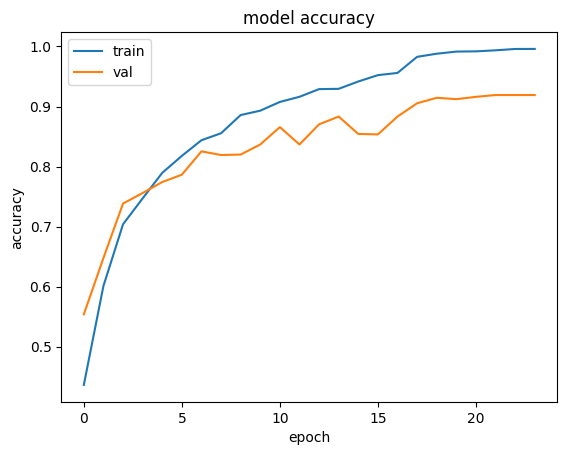

In [12]:
plt.plot(SSL_model_2.history['accuracy'])
plt.plot(SSL_model_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

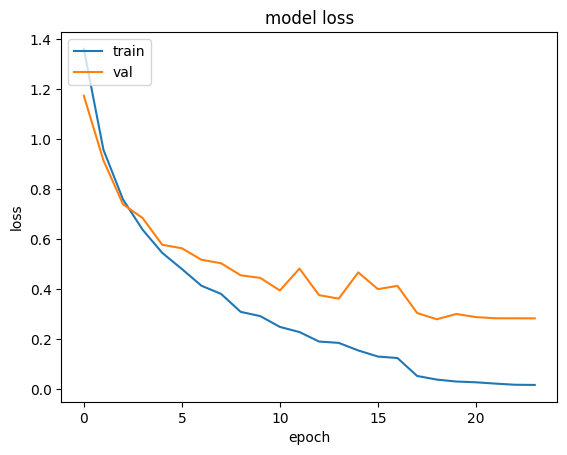

In [13]:
plt.plot(SSL_model_2.history['loss'])
plt.plot(SSL_model_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


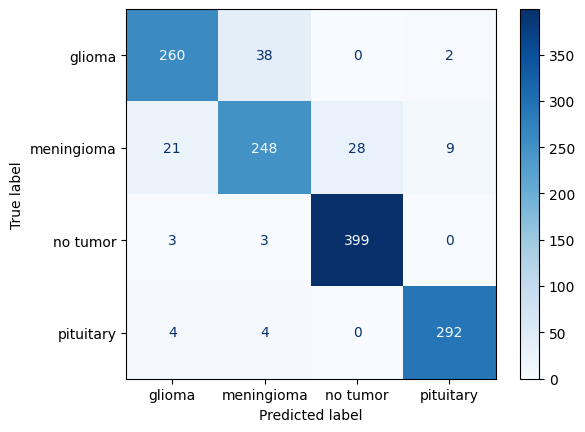

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.concatenate([y for x, y in test_data], axis=0)
# Use model_test instead of model
y_pred = model_2.predict(test_data)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["glioma", "meningioma", "no tumor", "pituitary"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [25]:
import os

# Define the training folder path
TRAINING_FOLDER = "BT100/Training"

# Ensure the folder exists
if not os.path.exists(TRAINING_FOLDER):
    print(f"Error: Folder '{TRAINING_FOLDER}' does not exist.")
else:
    # Get all class folders
    class_folders = [f for f in os.listdir(TRAINING_FOLDER) if os.path.isdir(os.path.join(TRAINING_FOLDER, f))]

    print("Class-wise file count in Training folder:")
    for class_name in class_folders:
        class_path = os.path.join(TRAINING_FOLDER, class_name)
        file_count = len([f for f in os.listdir(class_path) if f.endswith(('png', 'jpg', 'jpeg'))])
        print(f"{class_name}: {file_count} images")


Class-wise file count in Training folder:
pituitary: 2187 images
glioma: 4726 images
notumor: 2394 images
meningioma: 2010 images


In [23]:
import os

TRAIN_DIR = "F3-10"

# Count image files
image_files = [f for f in os.listdir(TRAIN_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(f"Total number of images in '{TRAIN_DIR}': {len(image_files)}")


Total number of images in 'F3-10': 1080


In [22]:
#Data Augmentaion of 10% unlabelled
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Define paths
TRAIN_DIR = "F3-10"

# Define augmentation functions
def augment_image(image):
    """Apply rotation, flipping, zoom, brightness, and contrast adjustments."""

    # Random Rotation (-20 to +20 degrees)
    image = tf.image.rot90(image, k=random.choice([0, 1, 2, 3]))

    # Random Flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random Zoom (Crop and Resize)
    crop_fraction = random.uniform(0.7, 1.0)  # Zoom range
    img_shape = tf.shape(image)

    # Cast img_shape elements to float32 before multiplication
    crop_size = [int(tf.cast(img_shape[0], tf.float32) * crop_fraction),
                 int(tf.cast(img_shape[1], tf.float32) * crop_fraction), 3]

    image = tf.image.random_crop(image, crop_size)
    image = tf.image.resize(image, (img_shape[0], img_shape[1]))

    # Random Brightness and Contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image

# Get image files
image_files = [f for f in os.listdir(TRAIN_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
num_augmented = len(image_files) * 2  # Generate double the dataset size

for i in range(num_augmented):
    img_name = random.choice(image_files)  # Pick a random image
    img_path = os.path.join(TRAIN_DIR, img_name)

    # Load image
    image = load_img(img_path)
    image = img_to_array(image) / 255.0  # Normalize

    # Apply augmentation
    augmented_image = augment_image(image)

    # Convert back to image
    augmented_image = array_to_img(augmented_image)

    # Save augmented image in the same folder
    new_filename = f"aug_{i}_{img_name}"
    augmented_image.save(os.path.join(TRAIN_DIR, new_filename))

print("Augmentation complete! Images saved in the existing training folder.")


Augmentation complete! Images saved in the existing training folder.


In [24]:
#Stacking 10% data into the Training
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tqdm import tqdm

# Define paths
MODEL_PATH = "SL_50_model(95).h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "F3-10"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
CONFIDENCE_THRESHOLD = 0.90
IMG_SIZE = (128, 128)

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])
        output_path = os.path.join(class_folder, img_file)
        img.save(output_path)

print("Pseudo-labeling completed. Check the output folder for labeled images.")

  0%|          | 0/1080 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


  0%|          | 1/1080 [00:00<12:03,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 3/1080 [00:00<04:01,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 5/1080 [00:00<02:34,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|          | 7/1080 [00:01<02:09,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 9/1080 [00:01<01:49,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|          | 11/1080 [00:01<01:36, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 13/1080 [00:01<01:28, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|▏         | 15/1080 [00:01<01:30, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 17/1080 [00:01<01:28, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 19/1080 [00:02<01:22, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 21/1080 [00:02<01:19, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▏         | 23/1080 [00:02<01:40, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


  2%|▏         | 25/1080 [00:02<02:13,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 26/1080 [00:02<02:22,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 28/1080 [00:03<01:58,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 30/1080 [00:03<01:43, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 32/1080 [00:03<01:34, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 34/1080 [00:03<01:27, 12.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 36/1080 [00:03<01:22, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▎         | 38/1080 [00:03<01:26, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▎         | 40/1080 [00:04<01:21, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 42/1080 [00:04<01:18, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 44/1080 [00:04<01:15, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 46/1080 [00:04<01:15, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 48/1080 [00:04<01:14, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▍         | 50/1080 [00:04<01:13, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▍         | 52/1080 [00:04<01:19, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 54/1080 [00:05<01:23, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▌         | 56/1080 [00:05<01:19, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  5%|▌         | 58/1080 [00:05<01:17, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 60/1080 [00:05<01:15, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 62/1080 [00:05<01:13, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▌         | 64/1080 [00:05<01:18, 12.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 66/1080 [00:05<01:16, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▋         | 68/1080 [00:06<01:13, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▋         | 70/1080 [00:06<01:11, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 72/1080 [00:06<01:09, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 74/1080 [00:06<01:10, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 76/1080 [00:06<01:09, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 78/1080 [00:06<01:14, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 80/1080 [00:06<01:10, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 82/1080 [00:07<01:21, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 84/1080 [00:07<01:30, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 86/1080 [00:07<01:38, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 88/1080 [00:07<01:41,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 90/1080 [00:08<01:47,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▊         | 92/1080 [00:08<01:42,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  9%|▊         | 94/1080 [00:08<01:46,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|▉         | 95/1080 [00:08<01:46,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 96/1080 [00:08<01:50,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|▉         | 97/1080 [00:08<01:58,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  9%|▉         | 98/1080 [00:09<02:02,  8.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 99/1080 [00:09<02:07,  7.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  9%|▉         | 100/1080 [00:09<02:01,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 102/1080 [00:09<01:37, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|▉         | 104/1080 [00:09<01:45,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|▉         | 105/1080 [00:09<01:44,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|▉         | 106/1080 [00:09<01:51,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|▉         | 107/1080 [00:10<01:55,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|█         | 108/1080 [00:10<01:51,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|█         | 109/1080 [00:10<01:56,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|█         | 110/1080 [00:10<01:52,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|█         | 111/1080 [00:10<01:50,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 10%|█         | 112/1080 [00:10<01:57,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|█         | 113/1080 [00:10<01:52,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 114/1080 [00:10<01:53,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█         | 115/1080 [00:10<01:58,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█         | 116/1080 [00:11<02:01,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█         | 118/1080 [00:11<01:54,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█         | 119/1080 [00:11<01:50,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|█         | 120/1080 [00:11<01:55,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 11%|█         | 121/1080 [00:11<02:03,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█▏        | 122/1080 [00:11<02:03,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█▏        | 124/1080 [00:11<01:38,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 126/1080 [00:12<01:26, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 128/1080 [00:12<01:19, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 130/1080 [00:12<01:14, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 132/1080 [00:12<01:17, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 134/1080 [00:12<01:15, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 136/1080 [00:12<01:23, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 138/1080 [00:13<01:17, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 140/1080 [00:13<01:13, 12.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 13%|█▎        | 142/1080 [00:13<01:09, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 13%|█▎        | 144/1080 [00:13<01:07, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▎        | 146/1080 [00:13<01:11, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▎        | 148/1080 [00:13<01:16, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▍        | 150/1080 [00:13<01:12, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▍        | 152/1080 [00:14<01:15, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▍        | 154/1080 [00:14<01:11, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▍        | 156/1080 [00:14<01:14, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▍        | 158/1080 [00:14<01:11, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 160/1080 [00:14<01:16, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▌        | 162/1080 [00:14<01:12, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▌        | 164/1080 [00:15<01:08, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▌        | 166/1080 [00:15<01:06, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 16%|█▌        | 168/1080 [00:15<01:04, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|█▌        | 170/1080 [00:15<01:03, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▌        | 172/1080 [00:15<01:02, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 174/1080 [00:15<01:10, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▋        | 176/1080 [00:15<01:07, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▋        | 178/1080 [00:16<01:11, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 17%|█▋        | 180/1080 [00:16<01:07, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 17%|█▋        | 182/1080 [00:16<01:05, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 17%|█▋        | 184/1080 [00:16<01:04, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 17%|█▋        | 186/1080 [00:16<01:02, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 188/1080 [00:16<01:08, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 18%|█▊        | 190/1080 [00:17<01:11, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 18%|█▊        | 192/1080 [00:17<01:07, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 18%|█▊        | 194/1080 [00:17<01:05, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 196/1080 [00:17<01:08, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 18%|█▊        | 198/1080 [00:17<01:05, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▊        | 200/1080 [00:17<01:08, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 19%|█▊        | 202/1080 [00:17<01:05, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 19%|█▉        | 204/1080 [00:18<01:03, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▉        | 206/1080 [00:18<01:02, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 19%|█▉        | 208/1080 [00:18<01:01, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▉        | 210/1080 [00:18<00:59, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 20%|█▉        | 212/1080 [00:18<00:59, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 20%|█▉        | 214/1080 [00:18<00:58, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 20%|██        | 216/1080 [00:18<01:05, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|██        | 218/1080 [00:19<01:04, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|██        | 220/1080 [00:19<01:08, 12.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|██        | 222/1080 [00:19<01:22, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██        | 224/1080 [00:19<01:26,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██        | 226/1080 [00:20<01:36,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 21%|██        | 228/1080 [00:20<01:31,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██▏       | 230/1080 [00:20<01:27,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██▏       | 232/1080 [00:20<01:24, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 22%|██▏       | 234/1080 [00:20<01:33,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 22%|██▏       | 235/1080 [00:20<01:37,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|██▏       | 236/1080 [00:21<01:40,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 22%|██▏       | 237/1080 [00:21<01:39,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 22%|██▏       | 238/1080 [00:21<01:44,  8.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|██▏       | 239/1080 [00:21<01:40,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 22%|██▏       | 241/1080 [00:21<01:27,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▎       | 243/1080 [00:21<01:23, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 245/1080 [00:21<01:16, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 247/1080 [00:22<01:10, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 249/1080 [00:22<01:11, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 23%|██▎       | 251/1080 [00:22<01:06, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 253/1080 [00:22<01:03, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 24%|██▎       | 255/1080 [00:22<01:01, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 257/1080 [00:22<01:11, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▍       | 259/1080 [00:23<01:17, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▍       | 261/1080 [00:23<01:10, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▍       | 263/1080 [00:23<01:05, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▍       | 265/1080 [00:23<01:07, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▍       | 267/1080 [00:23<01:04, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 25%|██▍       | 269/1080 [00:23<01:03, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 25%|██▌       | 271/1080 [00:24<01:06, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 25%|██▌       | 273/1080 [00:24<01:02, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▌       | 275/1080 [00:24<01:00, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▌       | 277/1080 [00:24<00:58, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▌       | 279/1080 [00:24<00:56, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 281/1080 [00:24<00:56, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 283/1080 [00:24<01:06, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▋       | 285/1080 [00:25<01:12, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 27%|██▋       | 287/1080 [00:25<01:06, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 27%|██▋       | 289/1080 [00:25<01:02, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 27%|██▋       | 291/1080 [00:25<00:59, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 293/1080 [00:25<01:01, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 27%|██▋       | 295/1080 [00:26<01:52,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 297/1080 [00:26<01:36,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 299/1080 [00:26<01:28,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 301/1080 [00:26<01:18,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 303/1080 [00:26<01:12, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██▊       | 305/1080 [00:27<01:12, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 307/1080 [00:27<01:11, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 29%|██▊       | 309/1080 [00:27<01:06, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▉       | 311/1080 [00:27<01:11, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 313/1080 [00:27<01:08, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▉       | 315/1080 [00:28<01:03, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 317/1080 [00:28<01:02, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 30%|██▉       | 319/1080 [00:28<00:59, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|██▉       | 321/1080 [00:28<00:57, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 30%|██▉       | 323/1080 [00:28<00:55, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 325/1080 [00:28<00:59, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 30%|███       | 327/1080 [00:28<00:57, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 329/1080 [00:29<01:00, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███       | 331/1080 [00:29<00:58, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███       | 333/1080 [00:29<01:01, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 31%|███       | 335/1080 [00:29<01:02, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 337/1080 [00:29<01:09, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 31%|███▏      | 339/1080 [00:29<01:04, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 341/1080 [00:30<01:01, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 343/1080 [00:30<00:57, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 32%|███▏      | 345/1080 [00:30<00:55, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 32%|███▏      | 347/1080 [00:30<00:53, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 32%|███▏      | 349/1080 [00:30<01:01, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▎      | 351/1080 [00:30<01:03, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 33%|███▎      | 353/1080 [00:31<01:03, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 355/1080 [00:31<01:00, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 33%|███▎      | 357/1080 [00:31<00:57, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 33%|███▎      | 359/1080 [00:31<00:54, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 33%|███▎      | 361/1080 [00:31<01:04, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 34%|███▎      | 363/1080 [00:32<01:08, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 365/1080 [00:32<01:14,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|███▍      | 367/1080 [00:32<01:13,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 369/1080 [00:32<01:12,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 371/1080 [00:32<01:16,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 372/1080 [00:33<01:19,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▍      | 373/1080 [00:33<01:23,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 35%|███▍      | 374/1080 [00:33<01:25,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▍      | 375/1080 [00:33<01:28,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▍      | 376/1080 [00:33<01:29,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▍      | 377/1080 [00:33<01:32,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 378/1080 [00:33<01:28,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|███▌      | 380/1080 [00:33<01:11,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|███▌      | 382/1080 [00:34<01:07, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 36%|███▌      | 384/1080 [00:34<01:02, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 386/1080 [00:34<01:03, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▌      | 388/1080 [00:34<00:58, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 390/1080 [00:34<01:00, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▋      | 392/1080 [00:34<01:01, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|███▋      | 394/1080 [00:35<01:01, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 396/1080 [00:35<01:02, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 37%|███▋      | 398/1080 [00:35<01:01, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 400/1080 [00:35<01:05, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 402/1080 [00:35<01:04, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|███▋      | 404/1080 [00:36<01:03, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 406/1080 [00:36<01:02, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 38%|███▊      | 408/1080 [00:36<00:57, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 410/1080 [00:36<00:58, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 412/1080 [00:36<01:00, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 414/1080 [00:36<00:57, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███▊      | 416/1080 [00:37<01:00, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 418/1080 [00:37<00:56, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 39%|███▉      | 420/1080 [00:37<00:53, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 422/1080 [00:37<00:56, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▉      | 424/1080 [00:37<00:57, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███▉      | 426/1080 [00:38<00:58, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|███▉      | 428/1080 [00:38<00:58, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 40%|███▉      | 430/1080 [00:38<00:55, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 40%|████      | 432/1080 [00:38<00:56, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 434/1080 [00:38<00:58, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 436/1080 [00:38<01:02, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 438/1080 [00:39<00:57, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████      | 440/1080 [00:39<01:01, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 442/1080 [00:39<01:02, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 444/1080 [00:39<01:00, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████▏     | 446/1080 [00:39<00:57, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████▏     | 448/1080 [00:40<01:01, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 42%|████▏     | 450/1080 [00:40<00:56, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 42%|████▏     | 452/1080 [00:40<00:55, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 454/1080 [00:40<00:51, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 42%|████▏     | 456/1080 [00:40<00:51, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 458/1080 [00:40<00:53, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 43%|████▎     | 460/1080 [00:41<00:50, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 462/1080 [00:41<00:51, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 464/1080 [00:41<00:56, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 43%|████▎     | 466/1080 [00:41<00:51, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 468/1080 [00:41<00:52, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|████▎     | 470/1080 [00:41<00:50, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▎     | 472/1080 [00:42<00:55, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|████▍     | 474/1080 [00:42<00:55, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 476/1080 [00:42<00:52, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|████▍     | 478/1080 [00:42<00:52, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 480/1080 [00:42<00:53, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▍     | 482/1080 [00:43<01:00,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 484/1080 [00:43<00:58, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████▌     | 486/1080 [00:43<00:57, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|████▌     | 488/1080 [00:43<00:52, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 490/1080 [00:43<00:53, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 492/1080 [00:44<01:00,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 494/1080 [00:44<00:59,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 46%|████▌     | 496/1080 [00:44<01:01,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 497/1080 [00:44<01:01,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 46%|████▌     | 498/1080 [00:44<01:01,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 46%|████▌     | 499/1080 [00:44<01:04,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|████▋     | 500/1080 [00:44<01:03,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▋     | 501/1080 [00:45<01:07,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 502/1080 [00:45<01:09,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|████▋     | 503/1080 [00:45<01:11,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|████▋     | 504/1080 [00:45<01:11,  8.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 47%|████▋     | 505/1080 [00:45<01:09,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 47%|████▋     | 506/1080 [00:45<01:11,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 47%|████▋     | 507/1080 [00:45<01:14,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 508/1080 [00:45<01:16,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 509/1080 [00:46<01:16,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 47%|████▋     | 511/1080 [00:46<01:00,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 513/1080 [00:46<00:56, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 515/1080 [00:46<00:53, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 517/1080 [00:46<00:52, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 48%|████▊     | 519/1080 [00:46<00:48, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 48%|████▊     | 521/1080 [00:47<00:45, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 523/1080 [00:47<00:46, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 49%|████▊     | 525/1080 [00:47<00:43, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 49%|████▉     | 527/1080 [00:47<00:41, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 529/1080 [00:47<00:45, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|████▉     | 531/1080 [00:47<00:43, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 49%|████▉     | 533/1080 [00:48<00:42, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 50%|████▉     | 535/1080 [00:48<00:43, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 50%|████▉     | 537/1080 [00:48<00:41, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 50%|████▉     | 539/1080 [00:48<00:40, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 50%|█████     | 541/1080 [00:48<00:39, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|█████     | 543/1080 [00:48<00:43, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 50%|█████     | 545/1080 [00:48<00:44, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 51%|█████     | 547/1080 [00:49<00:48, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 51%|█████     | 549/1080 [00:49<00:44, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████     | 551/1080 [00:49<00:45, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 553/1080 [00:49<00:46, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 51%|█████▏    | 555/1080 [00:49<00:46, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 557/1080 [00:50<00:44, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 559/1080 [00:50<00:44, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 52%|█████▏    | 561/1080 [00:50<00:42, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 52%|█████▏    | 563/1080 [00:50<00:40, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 52%|█████▏    | 565/1080 [00:50<00:42, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 52%|█████▎    | 567/1080 [00:50<00:44, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 569/1080 [00:51<00:47, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 53%|█████▎    | 571/1080 [00:51<00:43, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 53%|█████▎    | 573/1080 [00:51<00:41, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 575/1080 [00:51<00:39, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 577/1080 [00:51<00:38, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▎    | 579/1080 [00:51<00:39, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 54%|█████▍    | 581/1080 [00:52<00:40, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 583/1080 [00:52<00:38, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 585/1080 [00:52<00:37, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 587/1080 [00:52<00:39, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▍    | 589/1080 [00:52<00:37, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 591/1080 [00:52<00:44, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 593/1080 [00:53<00:44, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▌    | 595/1080 [00:53<00:44, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▌    | 597/1080 [00:53<00:44, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▌    | 599/1080 [00:53<00:44, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 601/1080 [00:53<00:41, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 56%|█████▌    | 603/1080 [00:53<00:40, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 605/1080 [00:54<00:41, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▌    | 607/1080 [00:54<00:42, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 56%|█████▋    | 609/1080 [00:54<00:39, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 57%|█████▋    | 611/1080 [00:54<00:39, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 613/1080 [00:54<00:40, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 57%|█████▋    | 615/1080 [00:54<00:41, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 617/1080 [00:55<00:41, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 619/1080 [00:55<00:41, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|█████▊    | 621/1080 [00:55<00:40, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 58%|█████▊    | 623/1080 [00:55<00:40, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 625/1080 [00:55<00:40, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 58%|█████▊    | 627/1080 [00:56<00:40, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 629/1080 [00:56<00:45,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 631/1080 [00:56<00:48,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▊    | 632/1080 [00:56<00:50,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▊    | 633/1080 [00:56<00:49,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 59%|█████▊    | 634/1080 [00:56<00:49,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 635/1080 [00:57<00:51,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 636/1080 [00:57<00:50,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 637/1080 [00:57<00:50,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 638/1080 [00:57<00:50,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 639/1080 [00:57<00:51,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 640/1080 [00:57<00:53,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▉    | 641/1080 [00:57<00:52,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 642/1080 [00:57<00:51,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 60%|█████▉    | 643/1080 [00:58<00:55,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|█████▉    | 644/1080 [00:58<00:56,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 60%|█████▉    | 645/1080 [00:58<00:57,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|█████▉    | 646/1080 [00:58<00:57,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 60%|██████    | 648/1080 [00:58<00:43,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 650/1080 [00:58<00:38, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 652/1080 [00:58<00:41, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 61%|██████    | 654/1080 [00:59<00:39, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████    | 656/1080 [00:59<00:36, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 61%|██████    | 658/1080 [00:59<00:34, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 61%|██████    | 660/1080 [00:59<00:32, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████▏   | 662/1080 [00:59<00:31, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████▏   | 664/1080 [00:59<00:34, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 666/1080 [01:00<00:35, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 62%|██████▏   | 668/1080 [01:00<00:35, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 62%|██████▏   | 670/1080 [01:00<00:33, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 62%|██████▏   | 672/1080 [01:00<00:31, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 62%|██████▏   | 674/1080 [01:00<00:32, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 676/1080 [01:00<00:35, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 63%|██████▎   | 678/1080 [01:00<00:32, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 680/1080 [01:01<00:32, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 63%|██████▎   | 682/1080 [01:01<00:30, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 63%|██████▎   | 684/1080 [01:01<00:29, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 64%|██████▎   | 686/1080 [01:01<00:29, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▎   | 688/1080 [01:01<00:28, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 690/1080 [01:01<00:33, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 692/1080 [01:02<00:33, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 64%|██████▍   | 694/1080 [01:02<00:36, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 64%|██████▍   | 696/1080 [01:02<00:33, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 698/1080 [01:02<00:33, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 65%|██████▍   | 700/1080 [01:02<00:35, 10.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 702/1080 [01:03<00:37, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 65%|██████▌   | 704/1080 [01:03<00:33, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 65%|██████▌   | 706/1080 [01:03<00:33, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 66%|██████▌   | 708/1080 [01:03<00:33, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 710/1080 [01:03<00:33, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 66%|██████▌   | 712/1080 [01:03<00:33, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 714/1080 [01:04<00:31, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 66%|██████▋   | 716/1080 [01:04<00:31, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▋   | 718/1080 [01:04<00:29, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 67%|██████▋   | 720/1080 [01:04<00:27, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 722/1080 [01:04<00:27, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 724/1080 [01:04<00:29, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 726/1080 [01:05<00:29, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 728/1080 [01:05<00:30, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 68%|██████▊   | 730/1080 [01:05<00:30, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 68%|██████▊   | 732/1080 [01:05<00:28, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 734/1080 [01:05<00:29, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 68%|██████▊   | 736/1080 [01:05<00:30, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 738/1080 [01:06<00:28, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▊   | 740/1080 [01:06<00:31, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 69%|██████▊   | 742/1080 [01:06<00:28, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 69%|██████▉   | 744/1080 [01:06<00:28, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 746/1080 [01:06<00:29, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 748/1080 [01:06<00:27, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 750/1080 [01:07<00:30, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|██████▉   | 752/1080 [01:07<00:31, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 70%|██████▉   | 754/1080 [01:07<00:30, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|███████   | 756/1080 [01:07<00:28, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|███████   | 758/1080 [01:07<00:30, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 760/1080 [01:08<00:30, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 71%|███████   | 762/1080 [01:08<00:28, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████   | 764/1080 [01:08<00:30, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 766/1080 [01:08<00:31,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████   | 768/1080 [01:09<00:33,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 769/1080 [01:09<00:35,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████▏  | 770/1080 [01:09<00:36,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████▏  | 771/1080 [01:09<00:35,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████▏  | 772/1080 [01:09<00:35,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 773/1080 [01:09<00:37,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 72%|███████▏  | 774/1080 [01:09<00:36,  8.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 775/1080 [01:09<00:39,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 776/1080 [01:10<00:39,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 777/1080 [01:10<00:40,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 72%|███████▏  | 778/1080 [01:10<00:40,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 779/1080 [01:10<00:40,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 780/1080 [01:10<00:39,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▏  | 781/1080 [01:10<00:40,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▎  | 783/1080 [01:10<00:34,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 785/1080 [01:11<00:32,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 787/1080 [01:11<00:30,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 789/1080 [01:11<00:29,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 73%|███████▎  | 791/1080 [01:11<00:25, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 793/1080 [01:11<00:26, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▎  | 795/1080 [01:12<00:27, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 797/1080 [01:12<00:25, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 799/1080 [01:12<00:25, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 801/1080 [01:12<00:26, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 74%|███████▍  | 803/1080 [01:12<00:24, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▍  | 805/1080 [01:12<00:23, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▍  | 807/1080 [01:13<00:23, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▍  | 809/1080 [01:13<00:24, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▌  | 811/1080 [01:13<00:25, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 75%|███████▌  | 813/1080 [01:13<00:26, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▌  | 815/1080 [01:13<00:25, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 817/1080 [01:14<00:26,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 818/1080 [01:14<00:26,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 820/1080 [01:14<00:23, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 822/1080 [01:14<00:25, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▋  | 824/1080 [01:14<00:24, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 76%|███████▋  | 826/1080 [01:14<00:22, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 77%|███████▋  | 828/1080 [01:15<00:20, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 830/1080 [01:15<00:21, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|███████▋  | 832/1080 [01:15<00:23, 10.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 834/1080 [01:15<00:23, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 836/1080 [01:15<00:22, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 838/1080 [01:15<00:20, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 78%|███████▊  | 840/1080 [01:16<00:20, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 842/1080 [01:16<00:22, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 844/1080 [01:16<00:22, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 78%|███████▊  | 846/1080 [01:16<00:21, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 79%|███████▊  | 848/1080 [01:16<00:21, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████▊  | 850/1080 [01:17<00:21, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 79%|███████▉  | 852/1080 [01:17<00:19, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████▉  | 854/1080 [01:17<00:18, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████▉  | 856/1080 [01:17<00:20, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 858/1080 [01:17<00:21, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 80%|███████▉  | 860/1080 [01:18<00:20, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 80%|███████▉  | 862/1080 [01:18<00:20, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 80%|████████  | 864/1080 [01:18<00:18, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 866/1080 [01:18<00:20, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 868/1080 [01:18<00:20, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 870/1080 [01:18<00:21,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 81%|████████  | 872/1080 [01:19<00:21,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 81%|████████  | 873/1080 [01:19<00:21,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████  | 875/1080 [01:19<00:19, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 877/1080 [01:19<00:19, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████▏ | 879/1080 [01:19<00:20, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 881/1080 [01:20<00:20,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 882/1080 [01:20<00:20,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 883/1080 [01:20<00:21,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 82%|████████▏ | 884/1080 [01:20<00:21,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 886/1080 [01:20<00:18, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 888/1080 [01:20<00:18, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 890/1080 [01:20<00:18, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 892/1080 [01:21<00:20,  9.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 893/1080 [01:21<00:20,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 894/1080 [01:21<00:20,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████▎ | 895/1080 [01:21<00:20,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 896/1080 [01:21<00:20,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 897/1080 [01:21<00:20,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 898/1080 [01:21<00:21,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 899/1080 [01:22<00:22,  8.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 901/1080 [01:22<00:20,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████▎ | 902/1080 [01:22<00:21,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 84%|████████▎ | 903/1080 [01:22<00:21,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 84%|████████▎ | 904/1080 [01:22<00:22,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 905/1080 [01:22<00:22,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 906/1080 [01:22<00:22,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 907/1080 [01:23<00:22,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▍ | 909/1080 [01:23<00:19,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 911/1080 [01:23<00:16, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▍ | 913/1080 [01:23<00:16, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▍ | 915/1080 [01:23<00:15, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▍ | 917/1080 [01:24<00:15, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 919/1080 [01:24<00:15, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 85%|████████▌ | 921/1080 [01:24<00:15, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 85%|████████▌ | 923/1080 [01:24<00:13, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 925/1080 [01:24<00:14, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 927/1080 [01:24<00:14, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 929/1080 [01:25<00:14, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 86%|████████▌ | 931/1080 [01:25<00:13, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 86%|████████▋ | 933/1080 [01:25<00:13, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 87%|████████▋ | 935/1080 [01:25<00:13, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 937/1080 [01:25<00:13, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 87%|████████▋ | 939/1080 [01:26<00:13, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 941/1080 [01:26<00:13,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 943/1080 [01:26<00:13, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 945/1080 [01:26<00:12, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 947/1080 [01:26<00:12, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████▊ | 949/1080 [01:26<00:11, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 951/1080 [01:27<00:12, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 953/1080 [01:27<00:12, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 955/1080 [01:27<00:12,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 89%|████████▊ | 956/1080 [01:27<00:12,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▊ | 957/1080 [01:27<00:13,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 89%|████████▉ | 959/1080 [01:28<00:11, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▉ | 961/1080 [01:28<00:11, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▉ | 963/1080 [01:28<00:10, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 89%|████████▉ | 965/1080 [01:28<00:10, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|████████▉ | 967/1080 [01:28<00:10, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 90%|████████▉ | 969/1080 [01:28<00:10, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 90%|████████▉ | 971/1080 [01:29<00:10, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 90%|█████████ | 973/1080 [01:29<00:09, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 90%|█████████ | 975/1080 [01:29<00:09, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 977/1080 [01:29<00:09, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 979/1080 [01:29<00:09, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 91%|█████████ | 981/1080 [01:30<00:09, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 91%|█████████ | 983/1080 [01:30<00:08, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████ | 985/1080 [01:30<00:08, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████▏| 987/1080 [01:30<00:08, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|█████████▏| 989/1080 [01:30<00:08, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 92%|█████████▏| 991/1080 [01:30<00:08, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 993/1080 [01:31<00:08, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 995/1080 [01:31<00:07, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 997/1080 [01:31<00:07, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▎| 999/1080 [01:32<00:14,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|█████████▎| 1000/1080 [01:32<00:14,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 93%|█████████▎| 1001/1080 [01:32<00:14,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 93%|█████████▎| 1002/1080 [01:32<00:13,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 93%|█████████▎| 1003/1080 [01:32<00:13,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 93%|█████████▎| 1004/1080 [01:33<00:12,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 93%|█████████▎| 1005/1080 [01:33<00:13,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 93%|█████████▎| 1006/1080 [01:33<00:16,  4.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 93%|█████████▎| 1007/1080 [01:34<00:21,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 93%|█████████▎| 1008/1080 [01:34<00:21,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 93%|█████████▎| 1009/1080 [01:34<00:21,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 94%|█████████▎| 1010/1080 [01:35<00:21,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 94%|█████████▎| 1011/1080 [01:35<00:22,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 94%|█████████▎| 1012/1080 [01:35<00:19,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 94%|█████████▍| 1013/1080 [01:35<00:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 94%|█████████▍| 1014/1080 [01:36<00:16,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|█████████▍| 1015/1080 [01:36<00:14,  4.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 94%|█████████▍| 1016/1080 [01:36<00:12,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 94%|█████████▍| 1017/1080 [01:36<00:11,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 94%|█████████▍| 1018/1080 [01:36<00:12,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 94%|█████████▍| 1019/1080 [01:36<00:12,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 94%|█████████▍| 1020/1080 [01:37<00:13,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 95%|█████████▍| 1021/1080 [01:37<00:11,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 95%|█████████▍| 1022/1080 [01:37<00:11,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 95%|█████████▍| 1023/1080 [01:37<00:12,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 95%|█████████▍| 1024/1080 [01:37<00:10,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▍| 1025/1080 [01:38<00:09,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 95%|█████████▌| 1026/1080 [01:38<00:09,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 95%|█████████▌| 1027/1080 [01:38<00:10,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 95%|█████████▌| 1028/1080 [01:38<00:10,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 95%|█████████▌| 1029/1080 [01:38<00:10,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▌| 1030/1080 [01:39<00:09,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 95%|█████████▌| 1031/1080 [01:39<00:08,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▌| 1032/1080 [01:39<00:07,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 96%|█████████▌| 1033/1080 [01:39<00:08,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 96%|█████████▌| 1034/1080 [01:39<00:10,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▌| 1035/1080 [01:40<00:10,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 1036/1080 [01:40<00:08,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 96%|█████████▌| 1038/1080 [01:40<00:06,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 96%|█████████▌| 1039/1080 [01:40<00:05,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▋| 1041/1080 [01:40<00:04,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 96%|█████████▋| 1042/1080 [01:40<00:04,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 97%|█████████▋| 1043/1080 [01:40<00:04,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 97%|█████████▋| 1044/1080 [01:41<00:04,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 1046/1080 [01:41<00:03, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 1048/1080 [01:41<00:02, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 97%|█████████▋| 1050/1080 [01:41<00:02, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 1052/1080 [01:41<00:02, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 98%|█████████▊| 1054/1080 [01:41<00:02, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 1056/1080 [01:42<00:02, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 1058/1080 [01:42<00:01, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 1060/1080 [01:42<00:01, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 98%|█████████▊| 1062/1080 [01:42<00:01, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▊| 1064/1080 [01:42<00:01, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▊| 1066/1080 [01:42<00:01, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 1068/1080 [01:43<00:01, 10.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▉| 1070/1080 [01:43<00:01,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 99%|█████████▉| 1072/1080 [01:43<00:00,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 1073/1080 [01:43<00:00,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 1074/1080 [01:44<00:00,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 1075/1080 [01:44<00:00,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


100%|█████████▉| 1076/1080 [01:44<00:00,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


100%|█████████▉| 1077/1080 [01:44<00:00,  5.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


100%|█████████▉| 1078/1080 [01:44<00:00,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


100%|█████████▉| 1079/1080 [01:45<00:00,  4.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


100%|██████████| 1080/1080 [01:45<00:00, 10.25it/s]

Pseudo-labeling completed. Check the output folder for labeled images.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_refined_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(4, activation='softmax')  # 4 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_3 = create_refined_model()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
SSL_model_3 = model_2.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)